<a href="https://colab.research.google.com/github/RVasconcelosMiguel/ComputerVision/blob/main/CV_Proj2_pre_p_teste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<Body>   
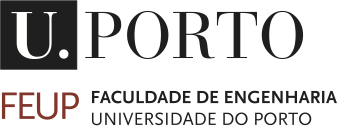   
<h1> <b>Computer Vision 2024/2025 (Assignment 2) </b> </h1>
<p>Master in Electrical and Computer Engineering </p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  

### **Developed by:**
*   Bernardo de Almeida Soeiro - up202008204
*   Rodrigo de Vasconcelos e Miguel - up202008406
*   Tomás Rosa Carreira - up202007783

FEUP, Dec. 2024

---


# **Proposal 3 - Classification of defects in photovoltaic modules**

Thermal inspection of photovoltaic (PV) modules is a non-invasive technique used to assess
the health and performance of solar panels. By capturing and analyzing the heat signatures
emitted by PV modules, thermal inspections can detect anomalies such as hotspots, dust
accumulation, or damaged cells. Hotspots, in particular, can indicate potential issues like
cell degradation or electrical faults. This proactive approach to maintenance allows for the
early identification of problems, reducing downtime and maximizing the overall efficiency
and lifespan of solar installations. Thermal inspection plays a crucial role in ensuring the
reliability and energy yield of PV systems, making it an essential tool in the field of solar
energy management and maintenance.

**Dataset:**

• Dataset Size: 20000 images.

• Annotations: Each image belongs to one of 12 classes (cell, cell-multi, cracking, hotspot, hot-spot-multi, shadowing, diode, diode-multi, vegetation, soiling, offline-module
and no-anomaly).

• Format: image.jpg and JSON file with image path and respective anomaly label.

# Dataset load and libraries import

In [1]:
pip install tqdm

In [2]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=87f179cfb4a001ddfa738af45aa679e5cb93d763549c7b6696d7a63a98a30cc4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [3]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR
from sklearn.metrics import f1_score


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from efficientnet_pytorch import EfficientNet
from torchvision.models import mobilenet_v2

import zipfile
import time
from PIL import Image, ImageFilter, ImageEnhance, ImageChops

import zipfile

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cuda:0 device


In [5]:
!rm -f -r "/content/images"
!rm -f "/content/module_metadata.json"

repo_path = "/content/InfraredSolarModules/"
zip_path = "/content/2020-02-14_InfraredSolarModules.zip"
extract_path = "/content"

!git clone https://github.com/RaptorMaps/InfraredSolarModules.git $repo_path
!mv "$repo_path/2020-02-14_InfraredSolarModules.zip" $extract_path
!unzip -uq $zip_path -d $extract_path

image_folder_path = "/content/InfraredSolarModules/images"
!mv $image_folder_path $extract_path

metadata_file_path = "/content/InfraredSolarModules/module_metadata.json"
!mv $metadata_file_path $extract_path

!ls /content


Cloning into '/content/InfraredSolarModules'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24 (delta 10), reused 12 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 5.49 MiB | 19.30 MiB/s, done.
Resolving deltas: 100% (10/10), done.
2020-02-14_InfraredSolarModules.zip  InfraredSolarModules  module_metadata.json
images				     __MACOSX		   sample_data


In [6]:
metadata_path = '/content/module_metadata.json'

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Convert metadata to DataFrame
df = pd.DataFrame.from_dict(metadata, orient='index')

# Preprocessing

**Original images**

Random Original Images



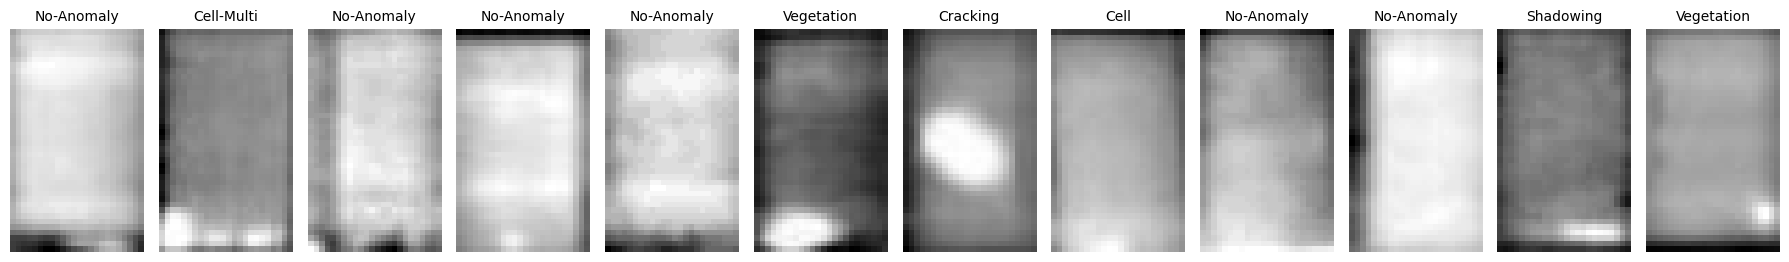

In [7]:
folder_path = '/content/images'

all_images = [file for file in os.listdir(folder_path) if file.endswith(('jpg'))]

# Randomly select 12 images
random_images = random.sample(all_images, 12)

# Display the selected images
plt.figure(figsize=(18, 10))
print("Random Original Images\n")
for i, image_name in enumerate(random_images):
    img_path = os.path.join(folder_path, image_name)
    img = Image.open(img_path)

    plt.subplot(1, 12, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    anomaly_label = df.loc[df['image_filepath'] == ('images'+'/'+image_name) , 'anomaly_class'].iloc[0]
    plt.title(anomaly_label, fontsize=10)

plt.tight_layout()
plt.show()


**Sharpenning the edges of the image**

The process involves the following steps:

1. **Smoothing the Image**: The original image is blurred using a low-pass filter (e.g., Gaussian or median filter) to create a smoothed version. Mathematically, this can be represented as:

   $$ I_{\text{blurred}} = \mathcal{F}(I) $$

   where F is the low-pass filter applied to the original image \( I \).

2. **Extracting Edges**: The smoothed image is subtracted from the original image to isolate the edges. This operation is defined as:

   $$ E = I - I_{\text{blurred}} $$

   where \( E \) represents the extracted edges.

3. **Sharpening**: The edges are amplified by a scaling factor alpha, between 0.2 and 0.7, and added back to the original image. The sharpened image I_sharp is then given by:

   $$ I_{\text{sharp}} = I + \alpha \cdot E $$

   where I_sharp is the final sharpened image.


In [8]:
# Create a folder for processed images
processed_folder = '/content/images_preprocessed'
os.makedirs(processed_folder, exist_ok=True)

for image_name in all_images:
    img_path = os.path.join(folder_path, image_name)
    processed_path = os.path.join(processed_folder, image_name)

    img = Image.open(img_path).convert('L')

    smoothed_img = img.filter(ImageFilter.GaussianBlur(radius=2))

    edge_mask = ImageChops.subtract(img, smoothed_img)

    scaling_factor = 0.5
    scaled_edge_mask = edge_mask.point(lambda p: p * scaling_factor)

    sharpened_img = ImageChops.add(img, scaled_edge_mask)

    sharpened_img.save(processed_path)

In [9]:
df_preprocessed = df.copy()

# Update the paths in the 'image_path' column
if 'image_filepath' in df_preprocessed.columns:
    df_preprocessed['image_filepath'] = df_preprocessed['image_filepath'].str.replace(
        'images/', 'images_preprocessed/', regex=False
    )

Preprocessed Images



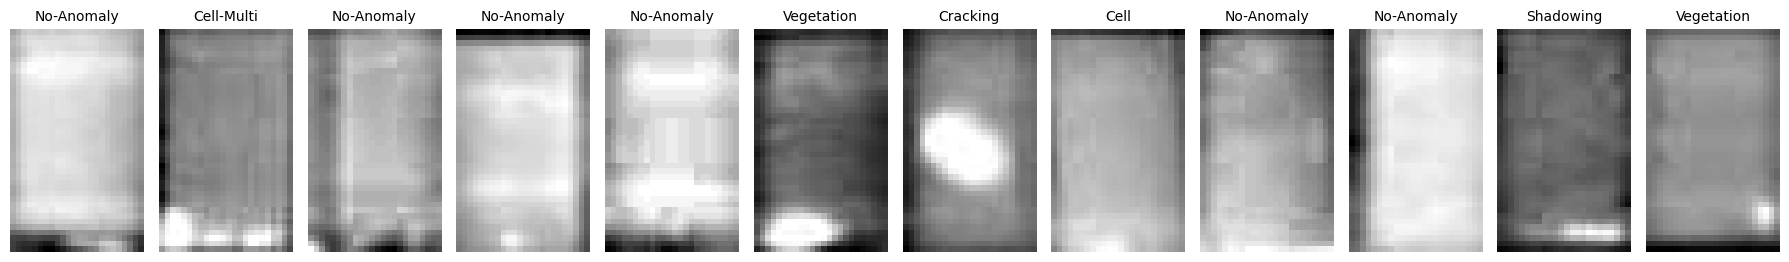

In [10]:
plt.figure(figsize=(18, 10))
print("Preprocessed Images\n")
for i, image_name in enumerate(random_images):
    processed_path = os.path.join(processed_folder, image_name)
    img = Image.open(processed_path)

    plt.subplot(1, 12, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    preprocessed_path = f'images_preprocessed/{image_name}'
    result = df_preprocessed.loc[df_preprocessed['image_filepath'] == preprocessed_path, 'anomaly_class'].iloc[0]
    plt.title(result, fontsize=10)

plt.tight_layout()
plt.show()

# 1

## a)  Model 1: Binary classification (anomaly or no-anomaly)


**Label assigment and data split**

In [ ]:
df_binary = df_preprocessed.copy()

# Substitution of the labels: anomaly->1 and no_anomaly->0
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

print(df_binary.tail(4))
print("\nDataset size:", df_binary.shape[0])

# Train/Test ratio
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Split into train + test/val
train_data, temp_data = train_test_split(df_binary, test_size=(1 - train_ratio), train_size=train_ratio, random_state=2, stratify=df_binary['anomaly_class'])

# Split validation and test
val_data, test_data = train_test_split(temp_data, test_size=0.5, train_size=0.5, random_state=2, stratify=temp_data['anomaly_class'])

train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


                      image_filepath  anomaly_class
8489    images_preprocessed/8489.jpg              1
7464    images_preprocessed/7464.jpg              1
18065  images_preprocessed/18065.jpg              0
13354  images_preprocessed/13354.jpg              0

Dataset size: 20000


**Dataset Class**

In [ ]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")


**Transforms**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Horizontal and Vertical flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.Resize((40, 40)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Color jitter
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

**Augmentation**

In [ ]:
# Initial dataset size
train_data_a_counts = train_data['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_a_counts)
print("\nInitial Size:", len(train_data), "\n")

train_data_a_balanced = train_data.copy()

# Folder creation for new images
directory = "/content/images_a"
if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
            else:
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
else:
    os.makedirs(directory, exist_ok=True)



for i in range(len(train_data)):
    row = train_data.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    # Perform augmentations
    n1 = random.randint(0, 2)
    n2 = random.randint(0, 2)

    while n2 == n1:
      n2 = random.randint(0, 2)
    for j in range(2):
      if(j==0):
        if(n1==0):
          transform_augmentation = transform_augmentation_1
        if(n1==1):
          transform_augmentation = transform_augmentation_2
        if(n1==2):
          transform_augmentation = transform_augmentation_3
      if(j==1):
        if(n2==0):
          transform_augmentation = transform_augmentation_1
        if(n2==1):
          transform_augmentation = transform_augmentation_2
        if(n2==2):
          transform_augmentation = transform_augmentation_3

      transformed_image = transform_augmentation(image_pil)
      if isinstance(transformed_image, torch.Tensor):
          transformed_image = transforms.ToPILImage()(transformed_image)
      new_image_path = os.path.join(directory, f"transformed_image_{i}_{j}.jpg")
      transformed_image.save(new_image_path, format="JPEG", quality=95)
      new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
      train_data_a_balanced = pd.concat([train_data_a_balanced, pd.DataFrame([new_row])], ignore_index=True)

# Final dataset size
train_data_a_balanced_counts = train_data_a_balanced['anomaly_class'].value_counts()
print("\n\nCount of each anomaly type(Augmented):")
print(train_data_a_balanced_counts)
print("\nAugmented Size:", len(train_data_a_balanced))

Counts of each anomaly type(Initial):
anomaly_class
0    8000
1    8000
Name: count, dtype: int64

Initial Size: 16000 



Count of each anomaly type(Augmented):
anomaly_class
0    24000
1    24000
Name: count, dtype: int64

Augmented Size: 48000


**Dataloaders**

In [ ]:
# Create the datasets for train, validation, and test
train_dataset = MyImageDataset(metadata=train_data_a_balanced, transform=train_transform)
val_dataset = MyImageDataset(metadata=val_data, transform=test_transform)  # Use test_transform for validation (same as test)
test_dataset = MyImageDataset(metadata=test_data, transform=test_transform)

batch_size = 16
# Create DataLoader for each dataset
train_loader_a = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader_a = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader_a = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Image Size:  torch.Size([1, 40, 40])


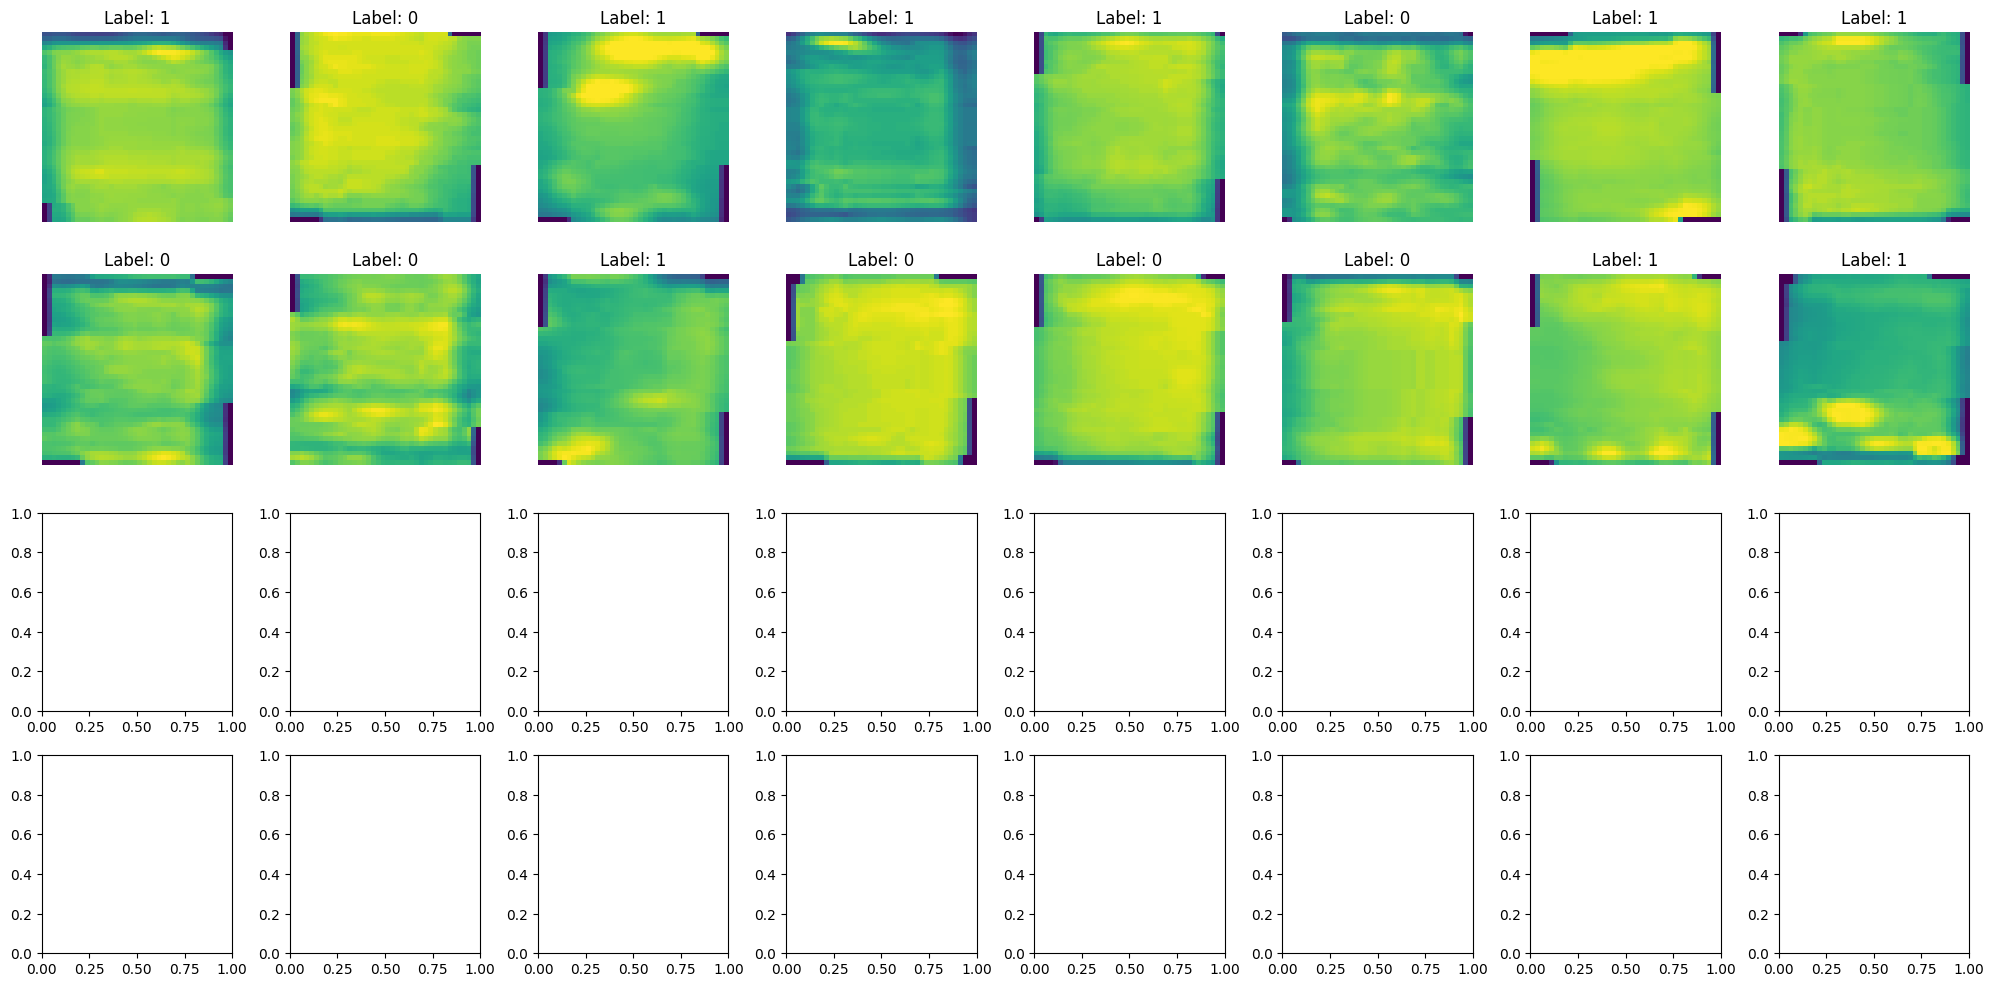

In [ ]:
# Show of 32 images
images, labels = next(iter(train_loader_a))

# Inverse of normalization
images = images * 0.5 + 0.5
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images)):
    image = images[i]
    image_pil = transforms.ToPILImage()(image)

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

print("Image Size: ", images[0].shape)
plt.tight_layout()
plt.show()

**Convolutional Neural Network**

In [ ]:
class Network_a(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)              # Input: (40x40x1), Output: (40x40x32)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)                          # Output: (20x20x32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)             # Output: (20x20x64)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)                          # Output: (10x10x64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)            # Output: (10x10x128)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)                          # Output: (5x5x128)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 5 * 5, 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)                             # Binary classification, 1 output neuron for sigmoid activation

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

model_a = Network_a()

# Define the loss function and optimizer
loss_fn_a = nn.BCEWithLogitsLoss()  # For binary classification
optimizer_a = torch.optim.Adam(model_a.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_a = ReduceLROnPlateau(optimizer_a, mode='min', factor=0.2, patience=5)

**Train and Test functions**

In [ ]:
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device):
    best_model = None
    best_val_acc = 0
    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            loss = loss_fn(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (torch.sigmoid(outputs.squeeze()) >= 0.5).float()
            train_acc += (preds == labels).sum().item() / len(labels)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs.squeeze(), labels.float())

                val_loss += loss.item()
                preds = (torch.sigmoid(outputs.squeeze()) >= 0.5).float()
                val_acc += (preds == labels).sum().item() / len(labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        scheduler.step(val_loss)

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

    # Return the best model
    model.load_state_dict(best_model)
    return model

In [ ]:
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim=True):

    model.eval()
    model.to(device)

    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            y_pred = model(images)

            loss = loss_fn(y_pred.squeeze(), labels.float())
            test_loss += loss.item()

            y_pred_class = (torch.sigmoid(y_pred.squeeze()) >= 0.5).float()
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)

            pred_labels.extend(y_pred_class.tolist())
            true_labels.extend(labels.tolist())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    if verbatim:
        print(f"Loss = {test_loss:.4f}, F1-Score = {f1:.4f}, Accuracy = {test_acc:.4f}")

    return pred_labels, test_loss, test_acc, f1

**Train**

Epoch 0/75 - Train Loss: 0.4999, Train Acc: 0.7554, Val Loss: 0.4008, Val Acc: 0.8260, Time: 59.60s
Epoch 1/75 - Train Loss: 0.3927, Train Acc: 0.8279, Val Loss: 0.3382, Val Acc: 0.8630, Time: 57.37s
Epoch 2/75 - Train Loss: 0.3618, Train Acc: 0.8460, Val Loss: 0.3150, Val Acc: 0.8755, Time: 58.41s
Epoch 3/75 - Train Loss: 0.3381, Train Acc: 0.8579, Val Loss: 0.3144, Val Acc: 0.8740, Time: 58.52s
Epoch 4/75 - Train Loss: 0.3261, Train Acc: 0.8629, Val Loss: 0.3104, Val Acc: 0.8700, Time: 58.69s
Epoch 5/75 - Train Loss: 0.3142, Train Acc: 0.8698, Val Loss: 0.2787, Val Acc: 0.8865, Time: 58.52s
Epoch 6/75 - Train Loss: 0.3045, Train Acc: 0.8734, Val Loss: 0.2750, Val Acc: 0.8855, Time: 58.53s
Epoch 7/75 - Train Loss: 0.2962, Train Acc: 0.8790, Val Loss: 0.2835, Val Acc: 0.8835, Time: 58.28s
Epoch 8/75 - Train Loss: 0.2888, Train Acc: 0.8831, Val Loss: 0.2592, Val Acc: 0.8970, Time: 57.86s
Epoch 9/75 - Train Loss: 0.2774, Train Acc: 0.8874, Val Loss: 0.2639, Val Acc: 0.9010, Time: 57.66s


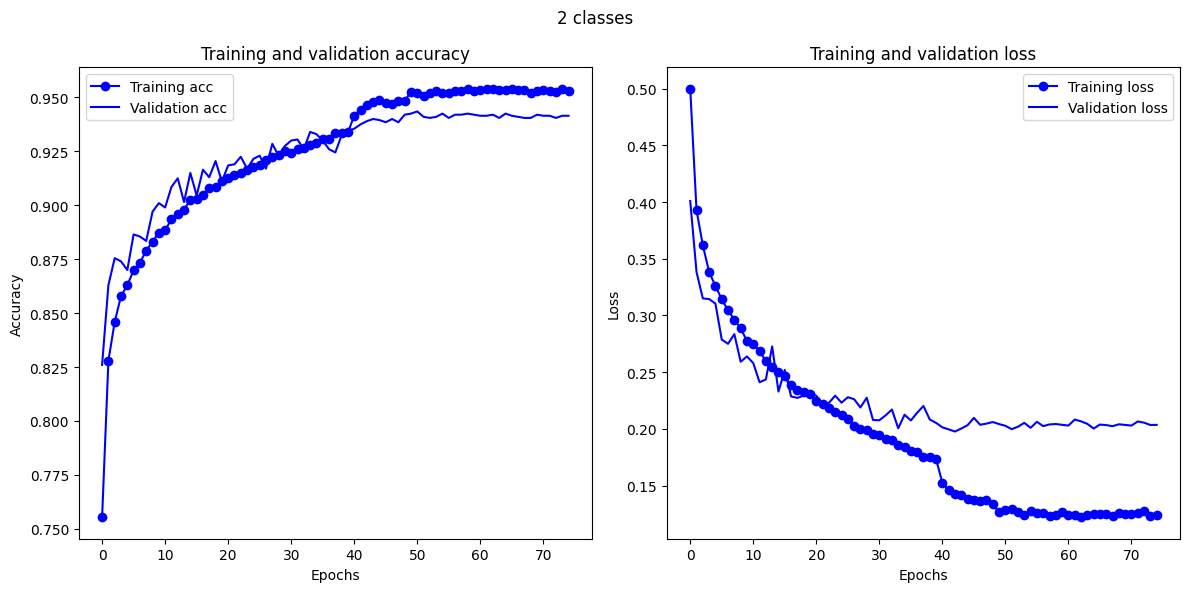

In [ ]:
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model_a.to(device)

best_model = train_and_validate(model_a,
                                train_loader_a,
                                val_loader_a,
                                loss_fn_a,
                                optimizer_a,
                                scheduler_a,
                                num_epochs=75,
                                device=device)

path_model = str("./myModel_best_a.pth")
path = path_model
saveModel(model_a, path=path)




plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, 'bo-', label='Training acc')
plt.plot(val_accuracies, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, 'bo-', label='Training loss')
plt.plot(val_losses, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("2 classes")  # Title for both plots
plt.tight_layout()
plt.show()


**Test**

Loss = 0.1844, F1-Score = 0.9480, Accuracy = 0.9480


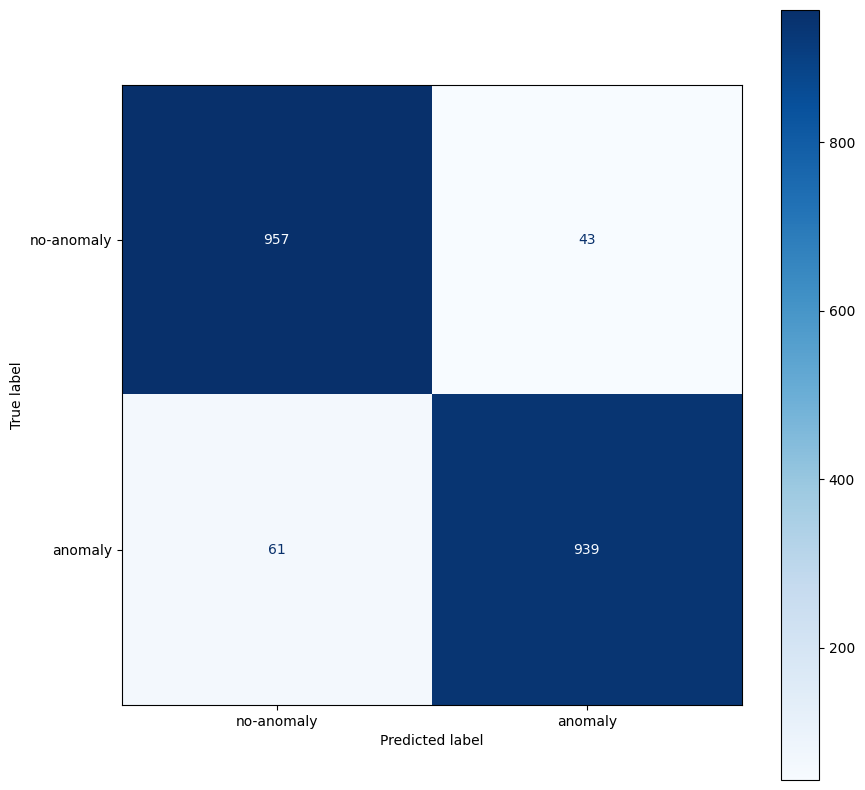

In [ ]:
# Load the model
model_a_test = Network_a()
model_a_test = model_a_test.to(device)
saved_model_path = "./myModel_best_a.pth"
checkpoint = torch.load(saved_model_path, map_location=device, weights_only=True)
model_a_test.load_state_dict(checkpoint)
model_a_test.eval()

y_pred_a, test_loss_a, test_acc_a, f1_score_a = test( model=model_a_test,
                                                      dataloader=test_loader_a,
                                                      loss_fn=loss_fn_a,
                                                      device=device,
                                                      verbatim=True)

# Confusion matrix
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

class_names_a = ['no-anomaly', 'anomaly']
plot_confusion_matrix(test_dataset.img_labels, y_pred_a, class_names_a)


## b) Model 2: Classification with 11 anomaly classes (cell, cell-multi, cracking, hotspot, hot-spot-multi, shadowing, diode, diode-multi, vegetation, soiling and offlinemodule)

**Lables assigment and data split**

In [ ]:
df_anomaly = df_preprocessed.copy()

# Filter out the "No-Anomaly" class
df_anomaly = df_anomaly[df_anomaly["anomaly_class"] != "No-Anomaly"]

# Substitution of label to a number
df_anomaly['anomaly_class'] = df_anomaly['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11
)

# Print the class distribution
anomaly_counts = df_anomaly['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(anomaly_counts)

# Train/Test ratio
train_ratio_b = 0.8
val_ratio_b = 0.1
test_ratio_b = 0.1

# Split into train + test/val
train_data_b, temp_data_b = train_test_split(df_anomaly, test_size=(1 - train_ratio_b), train_size=train_ratio_b, random_state=2, stratify=df_anomaly['anomaly_class'])

# Split validation and test
val_data_b, test_data_b = train_test_split(temp_data_b, test_size=0.5, train_size=0.5, random_state=2, stratify=temp_data_b['anomaly_class'])

train_data_b.reset_index(drop=True, inplace=True)
val_data_b.reset_index(drop=True, inplace=True)
test_data_b.reset_index(drop=True, inplace=True)

Counts of each anomaly type:
anomaly_class
0     1877
8     1639
6     1499
1     1288
5     1056
2      940
10     827
3      249
4      246
9      204
7      175
Name: count, dtype: int64


**Transforms**

In [ ]:
# Augmentattion transforms
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=(0.2, 0.5)),
    transforms.ToTensor(),
])

transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ColorJitter(brightness=(0.2, 0.5)),
    transforms.ToTensor(),
])

transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=(0.2, 0.5)),
    transforms.ToTensor(),
])

transform_aug = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((40, 40), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Train transform
train_transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.RandomRotation(5),
    transforms.RandomCrop((40, 40), padding=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

**Augmentation**

In [ ]:
train_data_b_counts = train_data_b['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_b_counts)
print("\nInitial Size:", len(train_data_b), "\n")

train_data_b_balanced = train_data_b.copy()

largest_class_count = train_data_b_counts.max()                  #
ratios = largest_class_count / train_data_b_counts               #
max_ratio = 6                                                    #
ratios = np.minimum(ratios, max_ratio)                           #
ratios_sorted = ratios.sort_index()                              #
ratios_matrix=[]                                                 # Ratios Calculations
                                                                 #
for label, ratio in ratios_sorted.items():                       #
    ratios_matrix.append([label, ratio])                         #
print(ratios_matrix)                                             #



directory = "/content/images_b"                                  #
if os.path.exists(directory):                                    #
    for filename in os.listdir(directory):                       #
        file_path = os.path.join(directory, filename)            #
        try:                                                     #
            if os.path.isdir(file_path):                         #
              shutil.rmtree(file_path)                           # Folder creation for new images
            else:                                                #
                os.remove(file_path)                             #
        except Exception as e:                                   #
            print(f"Error deleting file {file_path}: {e}")       #
else:                                                            #
    os.makedirs(directory, exist_ok=True)                        #


#Augmentation
for i in range(len(train_data_b)):
    row = train_data_b.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    ratio = ratios_matrix[int(label)][1]

    int_part = int(ratio)
    frac_part = ratio - int_part
    num1,num2 = random.sample(range(1, 3), 2)

    for n in range(int_part-1):
        random_number = random.randint(1, 3)
        transform_augmentation = transform_aug
        if(int_part==1):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==0):
            if(num1==1):
                transform_augmentation = transform_augmentation_1
            elif(num1==2):
                transform_augmentation = transform_augmentation_2
            elif(num1==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==1):
            if(num2==1):
                transform_augmentation = transform_augmentation_1
            elif(num2==2):
                transform_augmentation = transform_augmentation_2
            elif(num2==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==3 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==3 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==3 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==4 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==4 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==3):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_b_balanced = pd.concat([train_data_b_balanced, pd.DataFrame([new_row])], ignore_index=True)

    # Perform probabilistic augmentation for the fractional part
    if random.random() < frac_part:
        random_number = random.randint(1, 4)
        if(random_number==1):
            transform_augmentation = transform_augmentation_1
        elif(random_number==2):
            transform_augmentation = transform_augmentation_2
        elif(random_number==3):
            transform_augmentation = transform_augmentation_3
        elif(random_number==4):
            transform_augmentation = transform_aug
        transformed_image = transform_augmentation(image_pil)
        x=1
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_2_{int(label)}_{i}_{x}.jpg")
        x+=1
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_b_balanced = pd.concat([train_data_b_balanced, pd.DataFrame([new_row])], ignore_index=True)


train_data_b_balanced_counts = train_data_b_balanced['anomaly_class'].value_counts()
print("\n\nCounts of each anomaly type(Augmented):")
print(train_data_b_balanced_counts)
print("\nAugmented Size:", len(train_data_b_balanced))

Counts of each anomaly type(Initial):
anomaly_class
0     1502
8     1311
6     1199
1     1030
5      845
2      752
10     662
3      199
4      197
9      163
7      140
Name: count, dtype: int64

Initial Size: 8000 

[[0, 1.0], [1, 1.4582524271844661], [2, 1.997340425531915], [3, 6.0], [4, 6.0], [5, 1.7775147928994084], [6, 1.2527105921601334], [7, 6.0], [8, 1.1456903127383677], [9, 6.0], [10, 2.268882175226586]]


Counts of each anomaly type(Augmented):
anomaly_class
6     1523
1     1510
0     1502
10    1501
2     1501
8     1499
5     1496
3     1194
4     1182
9      978
7      840
Name: count, dtype: int64

Augmented Size: 14726


**Dataset class**

In [ ]:
class MyImageDataset_b(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):
        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

**Dataloaders**

In [ ]:
# Create the datasets for train, validation, and test
train_dataset_b = MyImageDataset_b(metadata=train_data_b_balanced, transform=train_transform)
val_dataset_b = MyImageDataset_b(metadata=val_data_b, transform=test_transform)  # Use test_transform for validation (same as test)
test_dataset_b = MyImageDataset_b(metadata=test_data_b, transform=test_transform)

batch_size = 16
# Create DataLoader for each dataset
train_loader_b = data.DataLoader(dataset=train_dataset_b, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader_b = data.DataLoader(dataset=val_dataset_b, batch_size=batch_size, shuffle=False)
test_loader_b = data.DataLoader(dataset=test_dataset_b, batch_size=batch_size, shuffle=False)

tensor(0)
torch.Size([1, 40, 40])


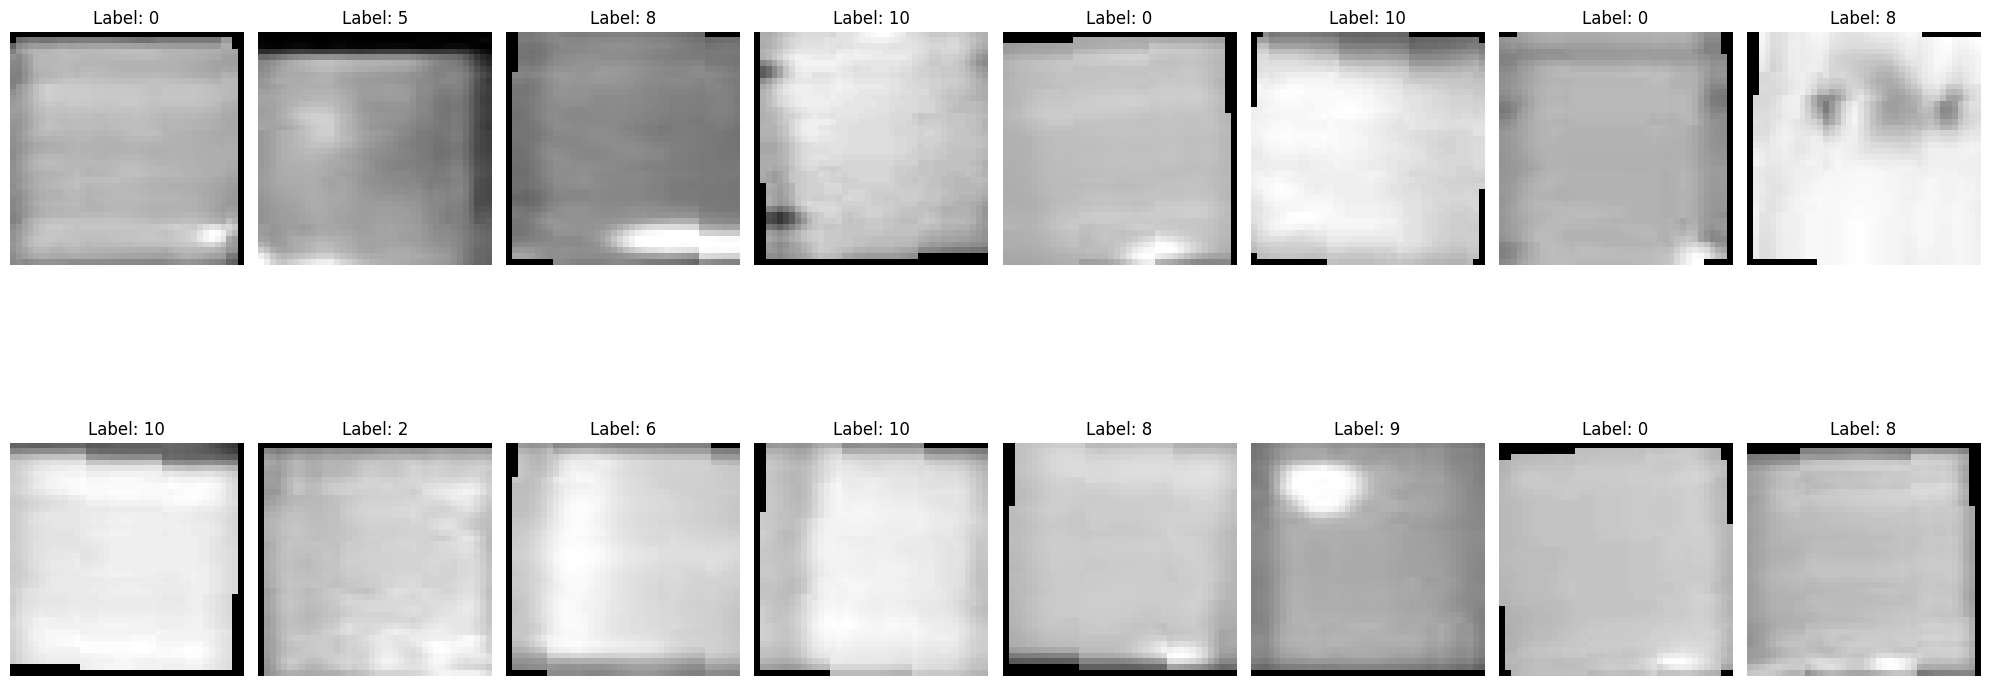

In [ ]:
# Show a batch
images_b, labels_b = next(iter(train_loader_b))
print(labels_b[0])

images_b = images_b * 0.5 + 0.5

fig, axes = plt.subplots(2, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images_b)):
    image = images_b[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil, cmap='gray')
    axes[i].set_title(f"Label: {labels_b[i].item()}")
    axes[i].axis('off')
print(images_b[0].shape)
plt.tight_layout()
plt.show()

**Train and test functions**

In [ ]:
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device):
    best_model = None
    best_val_acc = 0
    for epoch in range(num_epochs):
        start_time = time.time()  # Start timing the epoch

        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += (preds == labels).sum().item() / len(labels)
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += (preds == labels).sum().item() / len(labels)
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        scheduler.step(val_loss)
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

    model.load_state_dict(best_model)
    return model


In [ ]:
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim=True):

    model.eval()
    model.to(device)

    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            y_pred = model(images)

            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)

            pred_labels.extend(y_pred_class.tolist())
            true_labels.extend(labels.tolist())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    if verbatim:
        print(f"Loss = {test_loss:.4f}, F1-Score = {f1:.4f}, Accuracy = {test_acc:.4f}")

    return pred_labels, test_loss, test_acc, f1

**Convolution Neural Network**

In [ ]:
class Network_b(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)         # Initial 40x40
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)                     # Output size after Pool1: 20x20

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)                     # Output size after Pool2: 10x10

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)                     # Output size after Pool3: 5x5

        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)                     # Output size after Pool4: 2x2

        self.conv5 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool5 = nn.AdaptiveAvgPool2d((1, 1))           # Output size after Pool5: 1x1

        self.dropout_conv = nn.Dropout2d(0.4)

        self.fc1 = nn.Linear(1024, 512)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 11)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout_conv(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model_b = Network_b()

class_labels = train_data_b_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn_b = nn.CrossEntropyLoss(weight=class_weights).to(device)

optimizer_b = torch.optim.Adam(model_b.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler_b = ReduceLROnPlateau(optimizer_b, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


**Train**

Epoch 0/75 - Train Loss: 2.1314, Train Acc: 0.2137, Val Loss: 1.8904, Val Acc: 0.3671, Time: 20.71s
Epoch 1/75 - Train Loss: 1.7985, Train Acc: 0.3534, Val Loss: 1.4702, Val Acc: 0.4931, Time: 20.63s
Epoch 2/75 - Train Loss: 1.5593, Train Acc: 0.4473, Val Loss: 1.3643, Val Acc: 0.5317, Time: 22.39s
Epoch 3/75 - Train Loss: 1.4165, Train Acc: 0.5122, Val Loss: 1.1904, Val Acc: 0.5804, Time: 21.05s
Epoch 4/75 - Train Loss: 1.3250, Train Acc: 0.5460, Val Loss: 1.1391, Val Acc: 0.6032, Time: 23.22s
Epoch 5/75 - Train Loss: 1.2417, Train Acc: 0.5685, Val Loss: 1.2230, Val Acc: 0.5804, Time: 20.23s
Epoch 6/75 - Train Loss: 1.1844, Train Acc: 0.5872, Val Loss: 1.1161, Val Acc: 0.6002, Time: 21.44s
Epoch 7/75 - Train Loss: 1.1341, Train Acc: 0.6039, Val Loss: 1.1043, Val Acc: 0.6270, Time: 21.46s
Epoch 8/75 - Train Loss: 1.0987, Train Acc: 0.6159, Val Loss: 1.0559, Val Acc: 0.6171, Time: 20.28s
Epoch 9/75 - Train Loss: 1.0525, Train Acc: 0.6300, Val Loss: 1.0019, Val Acc: 0.6538, Time: 20.85s


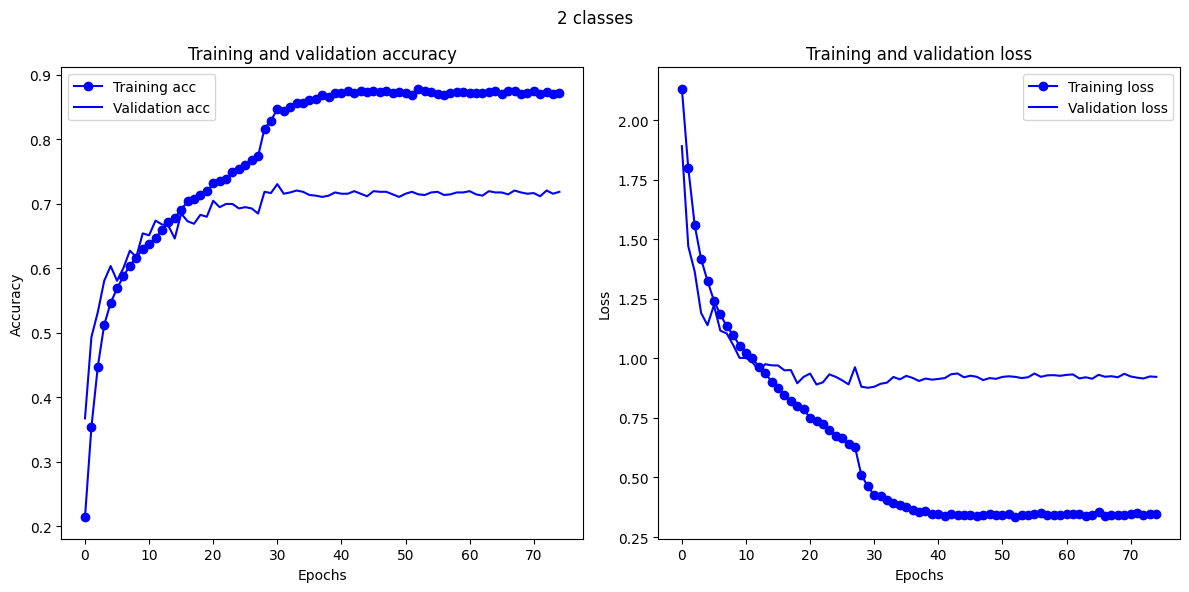

In [ ]:
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model_b.to(device)

best_model = train_and_validate(model_b,
                                train_loader_b,
                                val_loader_b,
                                loss_fn_b,
                                optimizer_b,
                                scheduler_b,
                                num_epochs=75,
                                device=device)

path_model = str("./myModel_best_A_b.pth")
path = path_model
saveModel(model_b, path=path)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, 'bo-', label='Training acc')
plt.plot(val_accuracies, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, 'bo-', label='Training loss')
plt.plot(val_losses, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("2 classes")  # Title for both plots
plt.tight_layout()
plt.show()


**Test**

Loss = 0.8855, F1-Score = 0.7282, Accuracy = 0.7272


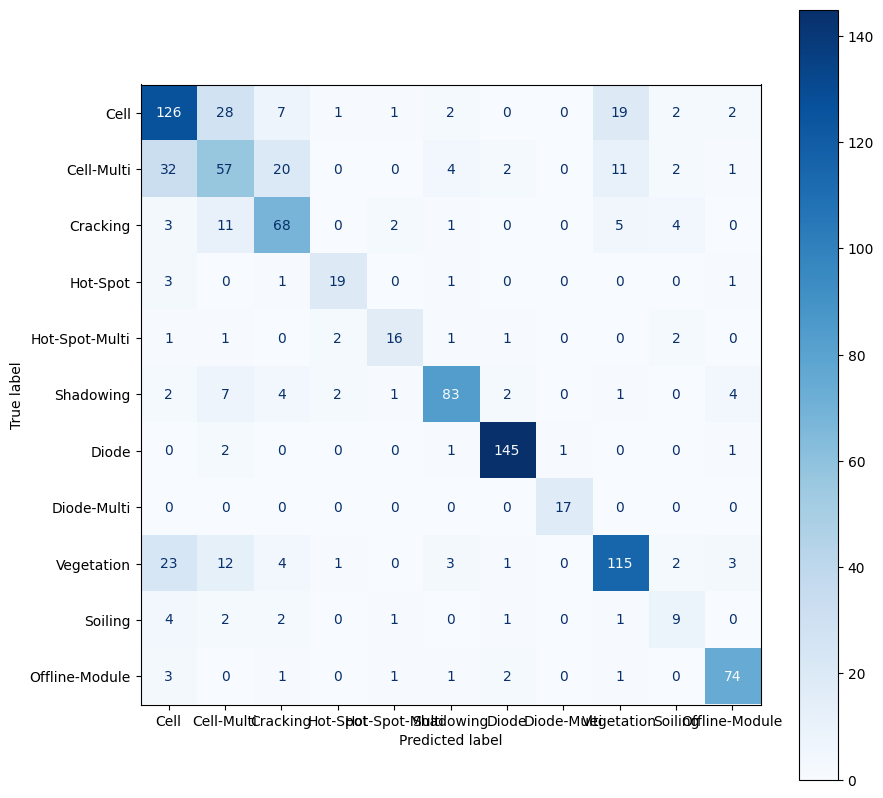

In [ ]:
model_b_test = Network_b()
model_b_test = model_b_test.to(device)
saved_model_path = "./myModel_best_A_b.pth"
checkpoint = torch.load(saved_model_path, map_location=device, weights_only=True)
model_b_test.load_state_dict(checkpoint)
model_b_test.eval()

y_pred_b, test_loss_b, test_acc_b, f1_score_b = test( model=model_b_test,
                                                      dataloader=test_loader_b,
                                                      loss_fn=loss_fn_b,
                                                      device=device,
                                                      verbatim=True)
# Confusion matrix
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

class_names_b = ['Cell', 'Cell-Multi', 'Cracking', 'Hot-Spot', 'Hot-Spot-Multi', 'Shadowing', 'Diode', 'Diode-Multi', 'Vegetation', 'Soiling', 'Offline-Module']
plot_confusion_matrix(test_dataset_b.img_labels, y_pred_b, class_names_b)

## c)  Model 3: Classification with 12 classes (cell, cell-multi, cracking, hot-spot, hotspot-multi, shadowing, diode, diode-multi, vegetation, soiling, offline-module and no-anomaly)

**Lable assigment and data split**

In [ ]:
# Binary Classification DataFrame
df_all_classes = df_preprocessed.copy()

# Substitution of string lables to numeric
df_all_classes['anomaly_class'] = df_all_classes['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11 if x == 'No-Anomaly'
              else 12
)

# Class distribution
df_all_classes_count = df_all_classes['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(df_all_classes_count)

#Train/Test ratio and split
train_ratio_c = 0.8

train_data_c, temp_data_c = train_test_split(df_all_classes, test_size=(1 - train_ratio_c), train_size=train_ratio_c, random_state=2, stratify=df_all_classes['anomaly_class'])
val_data_c, test_data_c = train_test_split(temp_data_c, test_size=0.5, train_size=0.5, random_state=2, stratify=temp_data_c['anomaly_class'])

train_data_c.reset_index(drop=True, inplace=True)
val_data_c.reset_index(drop=True, inplace=True)
test_data_c.reset_index(drop=True, inplace=True)

Counts of each anomaly type:
anomaly_class
11    10000
0      1877
8      1639
6      1499
1      1288
5      1056
2       940
10      827
3       249
4       246
9       204
7       175
Name: count, dtype: int64


**Transforms**

In [ ]:
# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.Resize((40, 40)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Agumentation transform
transform_aug = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((40, 40), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((40, 40)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

**Augmentation**

In [ ]:
train_data_c_counts = train_data_c['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_c_counts)
print("\nInitial Size:", len(train_data_c), "\n")

train_data_c_balanced = train_data_c.copy()


# Ratios calculations
second_largest = train_data_c_counts.nlargest(2).iloc[-1]
ratios = second_largest / train_data_c_counts
max_ratio = 4
ratios = np.minimum(ratios, max_ratio)
ratios = np.where(ratios >= 1, ratios * 2, ratios)
ratios = np.maximum(ratios, 1)
ratios = pd.Series(ratios, index=train_data_c_counts.index)
ratios_sorted = ratios.sort_index()
ratios_matrix=[]
for label, ratio in ratios_sorted.items():
    ratios_matrix.append([label, ratio])
print(ratios_matrix)



directory = "/content/images_c"                                     #
if os.path.exists(directory):                                       #
    for filename in os.listdir(directory):                          #
        file_path = os.path.join(directory, filename)               #
        try:                                                        #
            if os.path.isdir(file_path):                            #
                shutil.rmtree(file_path)                            # Folder creation for new images
            else:                                                   #
                os.remove(file_path)                                #
        except Exception as e:                                      #
            print(f"Error deleting file {file_path}: {e}")          #
else:                                                               #
    os.makedirs(directory, exist_ok=True)                           #


# Augmentation
for i in range(len(train_data_c)):
    row = train_data_c.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    ratio = ratios_matrix[int(label)][1]

    int_part = int(ratio)
    frac_part = ratio - int_part
    num1,num2 = random.sample(range(1, 3), 2)

    for n in range(int_part-1):
        random_number = random.randint(1, 3)

        transform_augmentation = transform_aug

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_c_balanced = pd.concat([train_data_c_balanced, pd.DataFrame([new_row])], ignore_index=True)

    if random.random() < frac_part:
        random_number = random.randint(1, 3)

        transform_augmentation = transform_aug

        transformed_image = transform_augmentation(image_pil)
        x=1
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_2_{int(label)}_{i}_{x}.jpg")
        x+=1
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_c_balanced = pd.concat([train_data_c_balanced, pd.DataFrame([new_row])], ignore_index=True)


train_data_c_balanced_counts = train_data_c_balanced['anomaly_class'].value_counts()
print("\n\nCounts of each anomaly type(Augmented):")
print(train_data_c_balanced_counts)
print("\nAugmented Size:", len(train_data_c_balanced))

Counts of each anomaly type(Initial):
anomaly_class
11    8000
0     1502
8     1311
6     1199
1     1030
5      845
2      752
10     662
3      199
4      197
9      163
7      140
Name: count, dtype: int64

Initial Size: 16000 

[[0, 2.0], [1, 2.9165048543689323], [2, 3.99468085106383], [3, 8.0], [4, 8.0], [5, 3.555029585798817], [6, 2.5054211843202667], [7, 8.0], [8, 2.2913806254767355], [9, 8.0], [10, 4.537764350453172], [11, 1.0]]


Counts of each anomaly type(Augmented):
anomaly_class
11    8000
1     3024
8     3014
5     3007
6     3007
0     3004
2     3002
10    2996
3     1592
4     1576
9     1304
7     1120
Name: count, dtype: int64

Augmented Size: 34646


**Image dataset class**

In [ ]:
class MyImageDataset_c(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

**Data loaders**

In [ ]:
# Create the datasets for train, validation, and test
train_dataset_c = MyImageDataset_c(metadata=train_data_c_balanced, transform=train_transform)
val_dataset_c = MyImageDataset_c(metadata=val_data_c, transform=test_transform)
test_dataset_c = MyImageDataset_c(metadata=test_data_c, transform=test_transform)

batch_size_c = 16
# Create DataLoader for each dataset
train_loader_c = data.DataLoader(dataset=train_dataset_c, batch_size=batch_size_c, shuffle=True, drop_last=True)
val_loader_c = data.DataLoader(dataset=val_dataset_c, batch_size=batch_size_c, shuffle=False)
test_loader_c = data.DataLoader(dataset=test_dataset_c, batch_size=batch_size_c, shuffle=False)


Image size torch.Size([1, 40, 40])


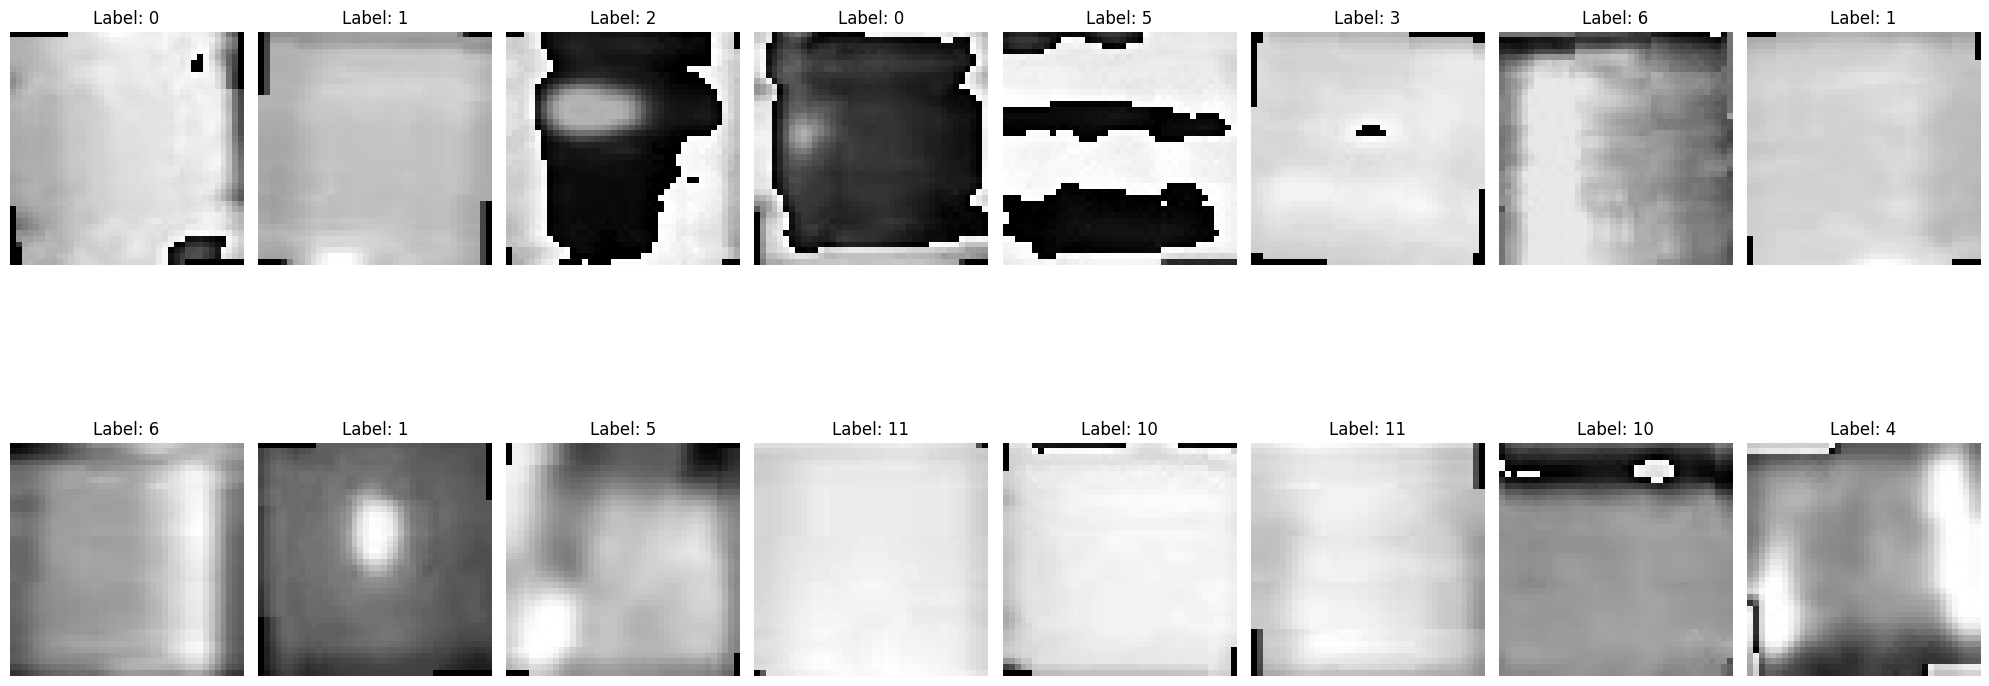

In [ ]:
# Show of a batch
images_c, labels_c = next(iter(train_loader_c))
images_c = images_c * 0.5 + 0.5

fig, axes = plt.subplots(2, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images_c)):
    image = images_c[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil, cmap='gray')
    axes[i].set_title(f"Label: {labels_c[i].item()}")
    axes[i].axis('off')

print("Image size", images_c[0].shape)
plt.tight_layout()
plt.show()

**Train and test functions**

In [ ]:
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device, early_stopping_patience=10):
    best_model = None
    best_val_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += (preds == labels).sum().item() / len(labels)
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += (preds == labels).sum().item() / len(labels)
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch}. Best Validation Accuracy: {best_val_acc:.4f}")
            break
        scheduler.step(val_loss)
        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")
    model.load_state_dict(best_model)
    return model


In [ ]:
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim=True):

    model.eval()
    model.to(device)

    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            y_pred = model(images)

            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            _, y_pred_class = torch.max(y_pred, 1)
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)

            pred_labels.extend(y_pred_class.tolist())
            true_labels.extend(labels.tolist())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    if verbatim:
        print(f"Loss = {test_loss:.4f}, F1-Score = {f1:.4f}, Accuracy = {test_acc:.4f}")

    return pred_labels, test_loss, test_acc, f1


**Convolutional Neural Network**

In [ ]:
class Network_c(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(512, 2048, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(2048)
        self.pool5 = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout_conv = nn.Dropout2d(0.2)

        self.fc1 = nn.Linear(2048, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 12)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout_conv(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model_c = Network_c()

class_labels = train_data_c_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn_c = nn.CrossEntropyLoss(weight=class_weights).to(device)

optimizer_c = torch.optim.Adam(model_c.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler_c = ReduceLROnPlateau(optimizer_c, mode='min', factor=0.2, patience=5)

**Train**

Epoch 0/75 - Train Loss: 1.9779, Train Acc: 0.3786, Val Loss: 1.3367, Val Acc: 0.6155, Time: 51.60s
Epoch 1/75 - Train Loss: 1.5646, Train Acc: 0.5085, Val Loss: 1.1173, Val Acc: 0.7040, Time: 48.95s
Epoch 2/75 - Train Loss: 1.3990, Train Acc: 0.5548, Val Loss: 1.0289, Val Acc: 0.7145, Time: 49.54s
Epoch 3/75 - Train Loss: 1.2893, Train Acc: 0.5866, Val Loss: 0.9694, Val Acc: 0.7495, Time: 49.53s
Epoch 4/75 - Train Loss: 1.1965, Train Acc: 0.6117, Val Loss: 0.9487, Val Acc: 0.7270, Time: 49.21s
Epoch 5/75 - Train Loss: 1.1171, Train Acc: 0.6359, Val Loss: 0.9263, Val Acc: 0.7455, Time: 49.58s
Epoch 6/75 - Train Loss: 1.0470, Train Acc: 0.6528, Val Loss: 0.9005, Val Acc: 0.7695, Time: 48.73s
Epoch 7/75 - Train Loss: 0.9812, Train Acc: 0.6699, Val Loss: 0.9489, Val Acc: 0.7260, Time: 49.18s
Epoch 8/75 - Train Loss: 0.9121, Train Acc: 0.6928, Val Loss: 0.8847, Val Acc: 0.7820, Time: 48.59s
Epoch 9/75 - Train Loss: 0.8495, Train Acc: 0.7138, Val Loss: 0.9050, Val Acc: 0.7735, Time: 49.02s


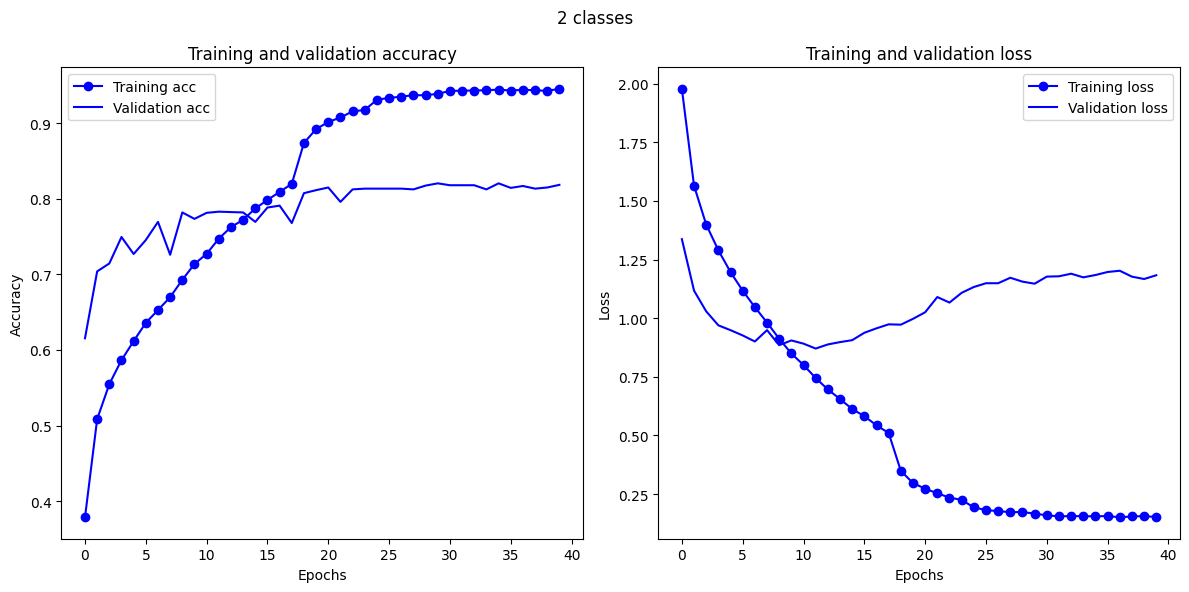

In [ ]:
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model_c.to(device)

early_stopping_patience_c = 10

best_model = train_and_validate(model_c,
                                train_loader_c,
                                val_loader_c,
                                loss_fn_c,
                                optimizer_c,
                                scheduler_c,
                                num_epochs=75,
                                device=device,
                                early_stopping_patience=early_stopping_patience_c)

path_model = str("./myModel_best_c.pth")
path = path_model
saveModel(model_c, path=path)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, 'bo-', label='Training acc')
plt.plot(val_accuracies, 'b-', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, 'bo-', label='Training loss')
plt.plot(val_losses, 'b-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("12 classes")
plt.tight_layout()
plt.show()


**Test**

Loss = 1.1641, F1-Score = 0.8159, Accuracy = 0.8190


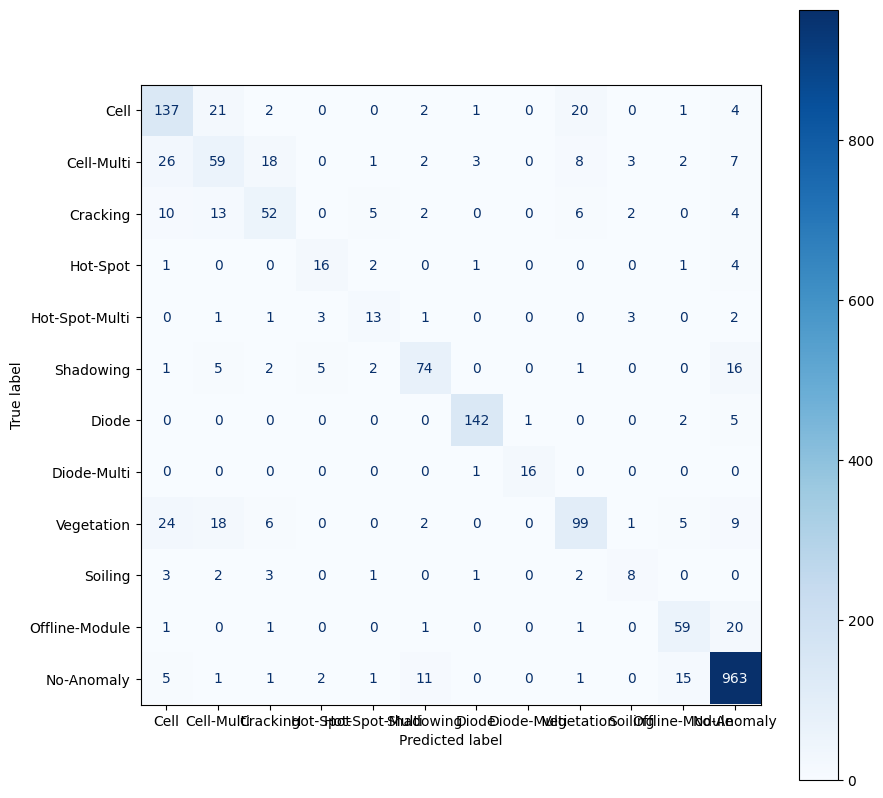

In [ ]:
model_c_test = Network_c()
model_c_test = model_c_test.to(device)
saved_model_path = "./myModel_best_c.pth"
checkpoint = torch.load(saved_model_path, map_location=device, weights_only=True)
model_c_test.load_state_dict(checkpoint)
model_c_test.eval()

y_pred_c, test_loss_c, test_acc_c, f1_score_c = test( model=model_c_test,
                                                      dataloader=test_loader_c,
                                                      loss_fn=loss_fn_c,
                                                      device=device,
                                                      verbatim=True)

# Confusion matrix
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

class_names_c = ['Cell', 'Cell-Multi', 'Cracking', 'Hot-Spot', 'Hot-Spot-Multi', 'Shadowing', 'Diode', 'Diode-Multi', 'Vegetation', 'Soiling', 'Offline-Module', 'No-Anomaly']
plot_confusion_matrix(test_dataset_c.img_labels, y_pred_c, class_names_c)


#2

## Dataset Augmentation Details

To enhance the dataset and improve model robustness, a series of augmentation transformations were applied to each image in the dataset:

- **Flipping Transformations:** Each image underwent one of three flipping operations:
  - Vertical flip
  - Horizontal flip
  - Combined vertical and horizontal flip

  These operations effectively quadruple the dataset size by introducing variations in orientation.


- **Random Rotation:** Applied with a maximum range of $\pm 10^\circ$.
- **Color Jittering:** Adjustments to brightness, contrast, hue and saturation with random variation parameters (brightness and contrast $\pm 20\%$).
- **Random Cropping:** Images were cropped to target dimensions with optional padding.
-**Gaussian Blur:** This transformation smooths the image by reducing high-frequency noise and fine details.

This augmentation strategy is designed to introduce variability into the dataset while preserving the essential characteristics of the images, thereby improving the generalization capability of the model.


# 3

Compare the results of your AI-model with at least 1 existing models.

In this case **EfficientNet** model is used.

EfficientNet provides excellent performance, often outperforming models like VGG, ResNet, and MobileNet on standard image classification tasks (even on smaller datasets). It's more efficient and accurate than MobileNet while still being relatively lightweight. Efficientnet offers different versions (like EfficientNet-B0, B1, B2, etc.) depending on your trade-off between speed and accuracy.

EfficientNet was chosen for its ability to deliver good performance while balancing accuracy and computational efficiency. Its approach allows it to achieve high accuracy with fewer parameters, making it ideal for tasks with limited resources and small image sizes like 40x24.

\
\begin{array}{|c|c|c|c|}
\hline
\textbf{Binary Model} & \textbf{Parameters} & \textbf{Accuracy} & \textbf{F1 Score} \\
\hline
\textbf{Our model} & 8.296.706 & 94.8\% & 0.984 \\
\hline
\textbf{EfficientNetB0} & 4.009.534 & 92.1\% & 0.92 \\
\hline
\end{array}

\
\begin{array}{|c|c|c|c|}
\hline
\textbf{11 class Model} & \textbf{Parameters} & \textbf{Accuracy} & \textbf{F1 Score} \\
\hline
\textbf{Our model} & 11.457.705 & 72.72\% & 0.728 \\
\hline
\textbf{EfficientNetB0} & 4.021.063 & \% &  \\
\hline
\end{array}


\
\begin{array}{|c|c|c|c|}
\hline
\textbf{12 class Model} & \textbf{Parameters} & \textbf{Accuracy} & \textbf{F1 Score} \\
\hline
\textbf{Our model} & 11.457.972 & 81.9\% & 0.816 \\
\hline
\textbf{EfficientNetB0} & 4.022.344 & \% &  \\
\hline
\end{array}


## a)

**Label assigment and data split**

In [ ]:
df_binary = df_preprocessed.copy()

# Substitution of the labels: anomaly->1 and no_anomaly->0
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

print(df_binary.tail(4))
print("\nDataset size:", df_binary.shape[0])

# Train/Validation/Test ratio
train_ratio_3a = 0.8
validation_ratio_3a = 0.1
test_ratio_3a = 0.1

# Splitting the dataset
train_data_3a, temp_data_3a = train_test_split(df_binary, test_size=(1-train_ratio_3a), train_size=train_ratio_3a, random_state=2, stratify=df_binary['anomaly_class'])

validation_data_3a, test_data_3a = train_test_split(temp_data_3a, test_size=(test_ratio_3a / (validation_ratio_3a + test_ratio_3a)), train_size=(validation_ratio_3a / (validation_ratio_3a + test_ratio_3a)), random_state=2, stratify=temp_data_3a['anomaly_class'])

# Reset indices for all splits
train_data_3a.reset_index(drop=True, inplace=True)
validation_data_3a.reset_index(drop=True, inplace=True)
test_data_3a.reset_index(drop=True, inplace=True)


                      image_filepath  anomaly_class
8489    images_preprocessed/8489.jpg              1
7464    images_preprocessed/7464.jpg              1
18065  images_preprocessed/18065.jpg              0
13354  images_preprocessed/13354.jpg              0

Dataset size: 20000


**Dataset class**

In [ ]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")


**Transforms**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Horizontal and Vertical flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),                          # Random rotation of 10 degrees
    transforms.RandomCrop((40, 24), padding=1),             # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Color jitter
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

**Data Augmentation**

In [ ]:
# Initial dataset size
train_data_3a_counts = train_data_3a['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_3a_counts)
print("\nInitial Size:", len(train_data_3a), "\n")

train_data_3a_balanced = train_data_3a.copy()

# Folder creation for new images
directory = "/content/images_3a"
if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
            else:
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
else:
    os.makedirs(directory, exist_ok=True)


num1, num2 = random.sample(range(1, 4), 2)
for i in range(len(train_data_3a)):
    row = train_data_3a.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    # Perform augmentations
    for n in range(2):
        if(n==0):
          if(num1==1):
            transform_augmentation = transform_augmentation_1
          if(num1==2):
            transform_augmentation = transform_augmentation_2
          if(num1==3):
            transform_augmentation = transform_augmentation_3
        if(n==1):
          if(num2==1):
            transform_augmentation = transform_augmentation_1
          if(num2==2):
            transform_augmentation = transform_augmentation_2
          if(num2==3):
            transform_augmentation = transform_augmentation_3

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_3a_balanced = pd.concat([train_data_3a_balanced, pd.DataFrame([new_row])], ignore_index=True)

# Final dataset size
train_data_3a_balanced_counts = train_data_3a_balanced['anomaly_class'].value_counts()
print("\n\nCount of each anomaly type(Augmented):")
print(train_data_3a_balanced_counts)
print("\nAugmented Size:", len(train_data_3a_balanced))

Counts of each anomaly type(Initial):
anomaly_class
0    8000
1    8000
Name: count, dtype: int64

Initial Size: 16000 



Count of each anomaly type(Augmented):
anomaly_class
0    24000
1    24000
Name: count, dtype: int64

Augmented Size: 48000


**Data Loaders**

In [ ]:
# DataLoaders
train_dataset_3a_balanced = MyImageDataset(metadata=train_data_3a_balanced, transform=train_transform)
test_dataset_3a = MyImageDataset(metadata=test_data_3a, transform=test_transform)
validation_dataset_3a = MyImageDataset(metadata=validation_data_3a, transform=test_transform)

#Batch size
batch_size_3a = 32
train_loader_3a = data.DataLoader(dataset=train_dataset_3a_balanced, batch_size=batch_size_3a, shuffle=True)
test_loader_3a = data.DataLoader(dataset=test_dataset_3a, batch_size=batch_size_3a, shuffle=False)
validation_loader_3a = data.DataLoader(dataset=validation_dataset_3a, batch_size=batch_size_3a, shuffle=False)

Image Size:  torch.Size([1, 224, 224])


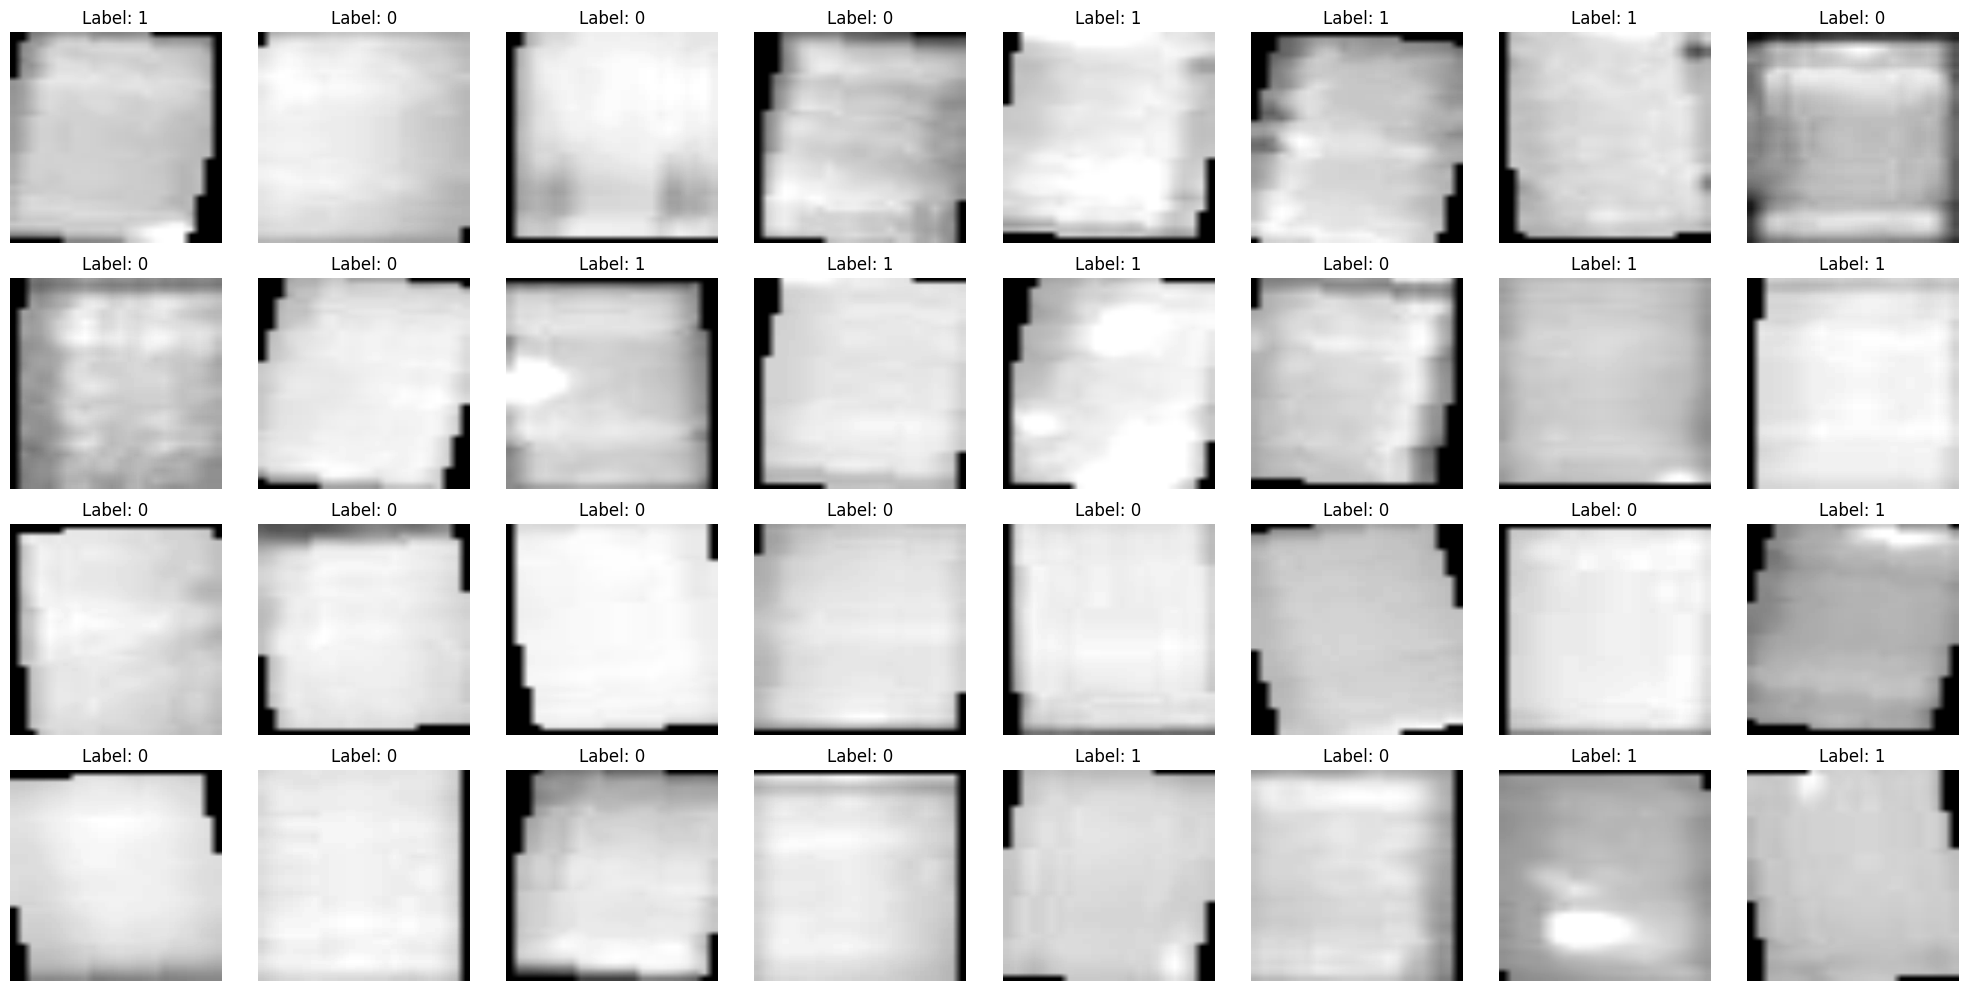

In [ ]:
# Show of 32 images
images, labels = next(iter(train_loader_3a))

images = images * 0.5 + 0.5
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images)):
    image = images[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil, cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

print("Image Size: ", images[0].shape)
plt.tight_layout()
plt.show()

**EficientNet Model**

In [ ]:
model_3a = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the first convolutional layer for grayscale images
model_3a._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the final fully connected layer for binary classification (1 output logit)
model_3a._fc = nn.Linear(model_3a._fc.in_features, 1)

model_3a = model_3a.to(device)

# Loss function
class_labels = train_data_3a_balanced['anomaly_class'].values
#Converting classes into a numpy array
classes = np.unique(class_labels) #Added this line
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn_3a = nn.BCEWithLogitsLoss(pos_weight=class_weights[1]).to(device)

# Optimizer and Scheduler
optimizer_3a = optim.Adam(model_3a.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_3a = optim.lr_scheduler.ReduceLROnPlateau(optimizer_3a, mode='min', factor=0.1, patience=5)


Loaded pretrained weights for efficientnet-b0


**EfficientNet train function**

In [ ]:
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device):
    best_model = None
    best_val_acc = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Adjust labels shape
            labels = labels.float()
            if len(labels.shape) > 1:
                labels = labels.squeeze()

            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.squeeze()  # Adjust outputs shape
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            train_acc += (preds == labels).sum().item() / len(labels)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Adjust labels shape
                labels = labels.float()
                if len(labels.shape) > 1:
                    labels = labels.squeeze()

                outputs = model(images)
                outputs = outputs.squeeze()  # Adjust outputs shape
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                preds = (torch.sigmoid(outputs) >= 0.5).float()
                val_acc += (preds == labels).sum().item() / len(labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()

        # Scheduler step
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        scheduler.step(val_loss)

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

    # Load the best model
    model.load_state_dict(best_model)
    return model, train_losses, val_losses, train_accuracies, val_accuracies


**EfficientNet test function**

In [ ]:
def test(model, dataloader, loss_fn, device):
    model.eval()
    model.to(device)

    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # Adjust labels shape
            labels = labels.float()
            if len(labels.shape) > 1:
                labels = labels.squeeze()

            outputs = model(images)
            outputs = outputs.squeeze()  # Adjust outputs shape

            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            preds = (torch.sigmoid(outputs) >= 0.5).float()
            test_acc += (preds == labels).sum().item() / len(labels)

            pred_labels.extend(preds.tolist())
            true_labels.extend(labels.tolist())

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    print(f"Test Loss: {test_loss:.4f}, Test F1-Score: {f1:.4f}, Test Accuracy: {test_acc:.4f}")
    return pred_labels, test_loss, test_acc, f1

**EfficientNet train loop**

Epoch 1/10 - Train Loss: 0.2528, Train Acc: 0.8224, Val Loss: 0.2315, Val Acc: 0.8666, Time: 382.47s
Epoch 2/10 - Train Loss: 0.1990, Train Acc: 0.8673, Val Loss: 0.1773, Val Acc: 0.8963, Time: 382.08s
Epoch 3/10 - Train Loss: 0.1741, Train Acc: 0.8869, Val Loss: 0.1679, Val Acc: 0.8998, Time: 381.25s
Epoch 4/10 - Train Loss: 0.1608, Train Acc: 0.8970, Val Loss: 0.1563, Val Acc: 0.9062, Time: 384.49s
Epoch 5/10 - Train Loss: 0.1514, Train Acc: 0.9029, Val Loss: 0.1660, Val Acc: 0.8993, Time: 390.05s
Epoch 6/10 - Train Loss: 0.1414, Train Acc: 0.9097, Val Loss: 0.1495, Val Acc: 0.9167, Time: 382.44s
Epoch 7/10 - Train Loss: 0.1374, Train Acc: 0.9126, Val Loss: 0.1557, Val Acc: 0.9097, Time: 380.67s
Epoch 8/10 - Train Loss: 0.1327, Train Acc: 0.9149, Val Loss: 0.1492, Val Acc: 0.9117, Time: 380.99s
Epoch 9/10 - Train Loss: 0.1289, Train Acc: 0.9200, Val Loss: 0.1449, Val Acc: 0.9167, Time: 380.59s
Epoch 10/10 - Train Loss: 0.1268, Train Acc: 0.9207, Val Loss: 0.1336, Val Acc: 0.9246, Tim

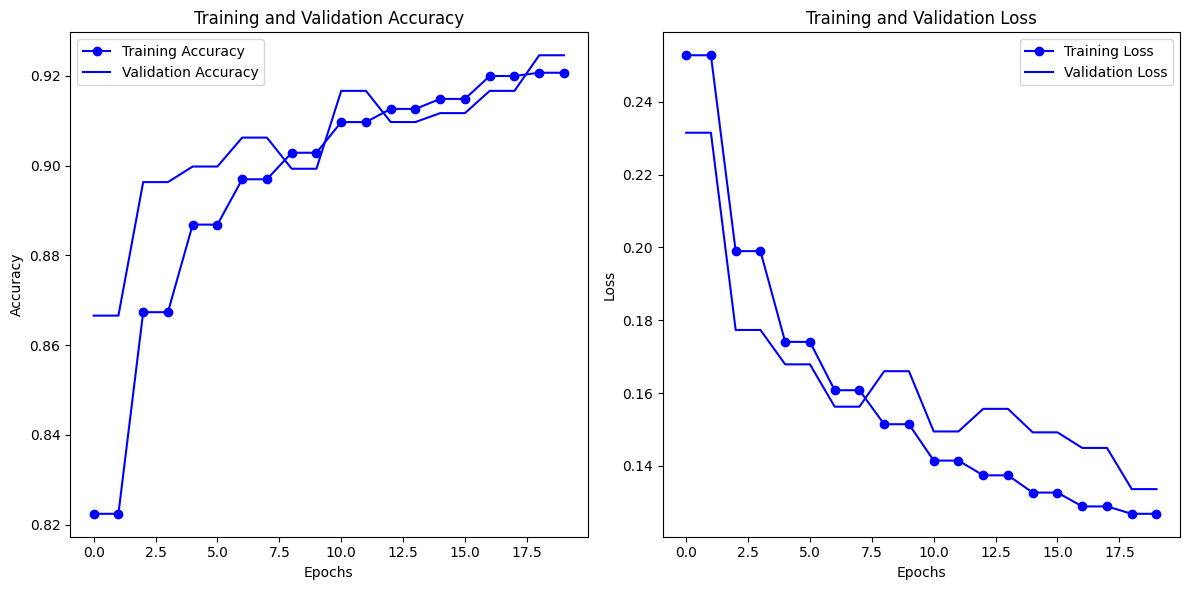

In [ ]:
def saveModel(model: nn.Module, path):
    torch.save(model.state_dict(), path)

# Training process
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 10
best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model_3a, train_loader_3a, validation_loader_3a, loss_fn_3a, optimizer_3a, scheduler_3a, num_epochs, device)

# Save the model
save_path = "./myModel_best_3a.pth"
saveModel(best_model, save_path)

# Plot Training and Validation Curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(val_accuracies, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, 'bo-', label='Training Loss')
plt.plot(val_losses, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**EfficientNet test and confusion matrix**

<ipython-input-68-2f0ac7578f59>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_3a.load_state_dict(torch.load("myModel_best_3a.pth"))


Test Loss: 0.1337, Test F1-Score: 0.9204, Test Accuracy: 0.9206


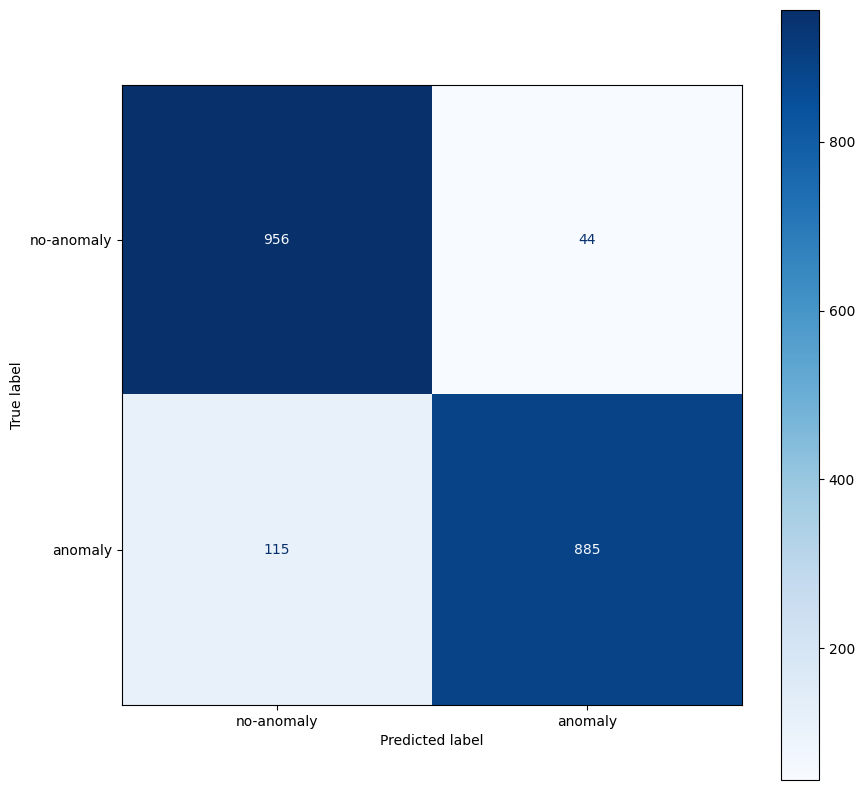

In [ ]:
# Load the model
model_3a.load_state_dict(torch.load("myModel_best_3a.pth"))
y_pred_3a, test_loss_3a, test_acc_3a, f1_score_3a = test( model=model_3a,
                                                          dataloader=test_loader_3a,
                                                          loss_fn=loss_fn_3a,
                                                          device=device
                                                          )

# Confusion matrix
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

class_names_3a = ['no-anomaly', 'anomaly']
plot_confusion_matrix(test_dataset_3a.img_labels, y_pred_3a, class_names_3a)


## b)

**Label assigment and data split**

In [11]:
df_anomaly = df_preprocessed.copy()

# Filter out the "No-Anomaly" class
df_anomaly = df_anomaly[df_anomaly["anomaly_class"] != "No-Anomaly"]

# Substitution of label to a number
df_anomaly['anomaly_class'] = df_anomaly['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11
)

# Print the class distribution
anomaly_counts = df_anomaly['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(anomaly_counts)

train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Split train and test
train_data_3b, temp_data = train_test_split(df_anomaly,test_size=(1 - train_ratio),random_state=2,stratify=df_anomaly['anomaly_class'])

# Split into validation and test sets
validation_data_3b, test_data_3b = train_test_split(temp_data,test_size=(test_ratio / (test_ratio + validation_ratio)), random_state=2, stratify=temp_data['anomaly_class'])

train_data_3b.reset_index(drop=True, inplace=True)
test_data_3b.reset_index(drop=True, inplace=True)
validation_data_3b.reset_index(drop=True, inplace=True)

Counts of each anomaly type:
anomaly_class
0     1877
8     1639
6     1499
1     1288
5     1056
2      940
10     827
3      249
4      246
9      204
7      175
Name: count, dtype: int64


**Transformations**

In [12]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical and horizontal flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Random aug
transform_aug = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Train transform
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),                          # Random 10 degrees rotation
    transforms.RandomCrop((224, 224), padding=1),             # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),   # Color jitter
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])             # Normalization
])

**Data Augmentation**

In [13]:
train_data_3b_counts = train_data_3b['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_3b_counts)
print("\nInitial Size:", len(train_data_3b), "\n")

train_data_3b_balanced = train_data_3b.copy()

largest_class_count = train_data_3b_counts.max()                  #
ratios = largest_class_count / train_data_3b_counts               #
max_ratio = 6                                                    #
ratios = np.minimum(ratios, max_ratio)                           #
ratios_sorted = ratios.sort_index()                              #
ratios_matrix=[]                                                 # Ratios Calculations
                                                                 #
for label, ratio in ratios_sorted.items():                       #
    ratios_matrix.append([label, ratio])                         #
print(ratios_matrix)                                             #



directory = "/content/images_3b"                                  #
if os.path.exists(directory):                                    #
    for filename in os.listdir(directory):                       #
        file_path = os.path.join(directory, filename)            #
        try:                                                     #
            if os.path.isdir(file_path):                         #
              shutil.rmtree(file_path)                           # Folder creation for new images
            else:                                                #
                os.remove(file_path)                             #
        except Exception as e:                                   #
            print(f"Error deleting file {file_path}: {e}")       #
else:                                                            #
    os.makedirs(directory, exist_ok=True)                        #


#Augmentation
for i in range(len(train_data_3b)):
    row = train_data_3b.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    ratio = ratios_matrix[int(label)][1]

    int_part = int(ratio)
    frac_part = ratio - int_part
    num1,num2 = random.sample(range(1, 3), 2)

    for n in range(int_part-1):
        random_number = random.randint(1, 3)
        transform_augmentation = transform_aug
        if(int_part==1):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==0):
            if(num1==1):
                transform_augmentation = transform_augmentation_1
            elif(num1==2):
                transform_augmentation = transform_augmentation_2
            elif(num1==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==1):
            if(num2==1):
                transform_augmentation = transform_augmentation_1
            elif(num2==2):
                transform_augmentation = transform_augmentation_2
            elif(num2==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==3 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==3 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==3 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==4 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==4 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==3):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_3b_balanced = pd.concat([train_data_3b_balanced, pd.DataFrame([new_row])], ignore_index=True)

    # Perform probabilistic augmentation for the fractional part
    if random.random() < frac_part:
        random_number = random.randint(1, 3)

        transform_augmentation = transform_aug

        transformed_image = transform_augmentation(image_pil)
        x=1
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_2_{int(label)}_{i}_{x}.jpg")
        x+=1
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_3b_balanced = pd.concat([train_data_3b_balanced, pd.DataFrame([new_row])], ignore_index=True)


train_data_3b_balanced_counts = train_data_3b_balanced['anomaly_class'].value_counts()
print("\n\nCounts of each anomaly type(Augmented):")
print(train_data_3b_balanced_counts)
print("\nAugmented Size:", len(train_data_3b_balanced))


Counts of each anomaly type(Initial):
anomaly_class
0     1502
8     1311
6     1199
1     1030
5      845
2      752
10     662
3      199
4      197
9      163
7      140
Name: count, dtype: int64

Initial Size: 8000 

[[0, 1.0], [1, 1.4582524271844661], [2, 1.997340425531915], [3, 6.0], [4, 6.0], [5, 1.7775147928994084], [6, 1.2527105921601334], [7, 6.0], [8, 1.1456903127383677], [9, 6.0], [10, 2.268882175226586]]


Counts of each anomaly type(Augmented):
anomaly_class
8     1509
10    1505
0     1502
2     1501
5     1498
1     1487
6     1483
3     1194
4     1182
9      978
7      840
Name: count, dtype: int64

Augmented Size: 14679


**Dataset Class**

In [14]:
class MyImageDataset_3b(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):
        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]
            if self.transform:
                image = self.transform(image)
            return image, torch.tensor(label, dtype=torch.long)
        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

**Train and test data loaders**

In [15]:
train_dataset_3b_balanced = MyImageDataset_3b(metadata=train_data_3b_balanced, transform=train_transform)
test_dataset_3b = MyImageDataset_3b(metadata=test_data_3b, transform=test_transform)
validation_dataset_3b = MyImageDataset_3b(metadata=validation_data_3b, transform=test_transform)

#Batch size
batch_size = 32
train_loader_3b = data.DataLoader(dataset=train_dataset_3b_balanced, batch_size=batch_size, shuffle=True)
test_loader_3b = data.DataLoader(dataset=test_dataset_3b, batch_size=batch_size, shuffle=False)
validation_loader_3b = data.DataLoader(dataset=validation_dataset_3b, batch_size=batch_size, shuffle=False)

tensor(4)
torch.Size([1, 224, 224])


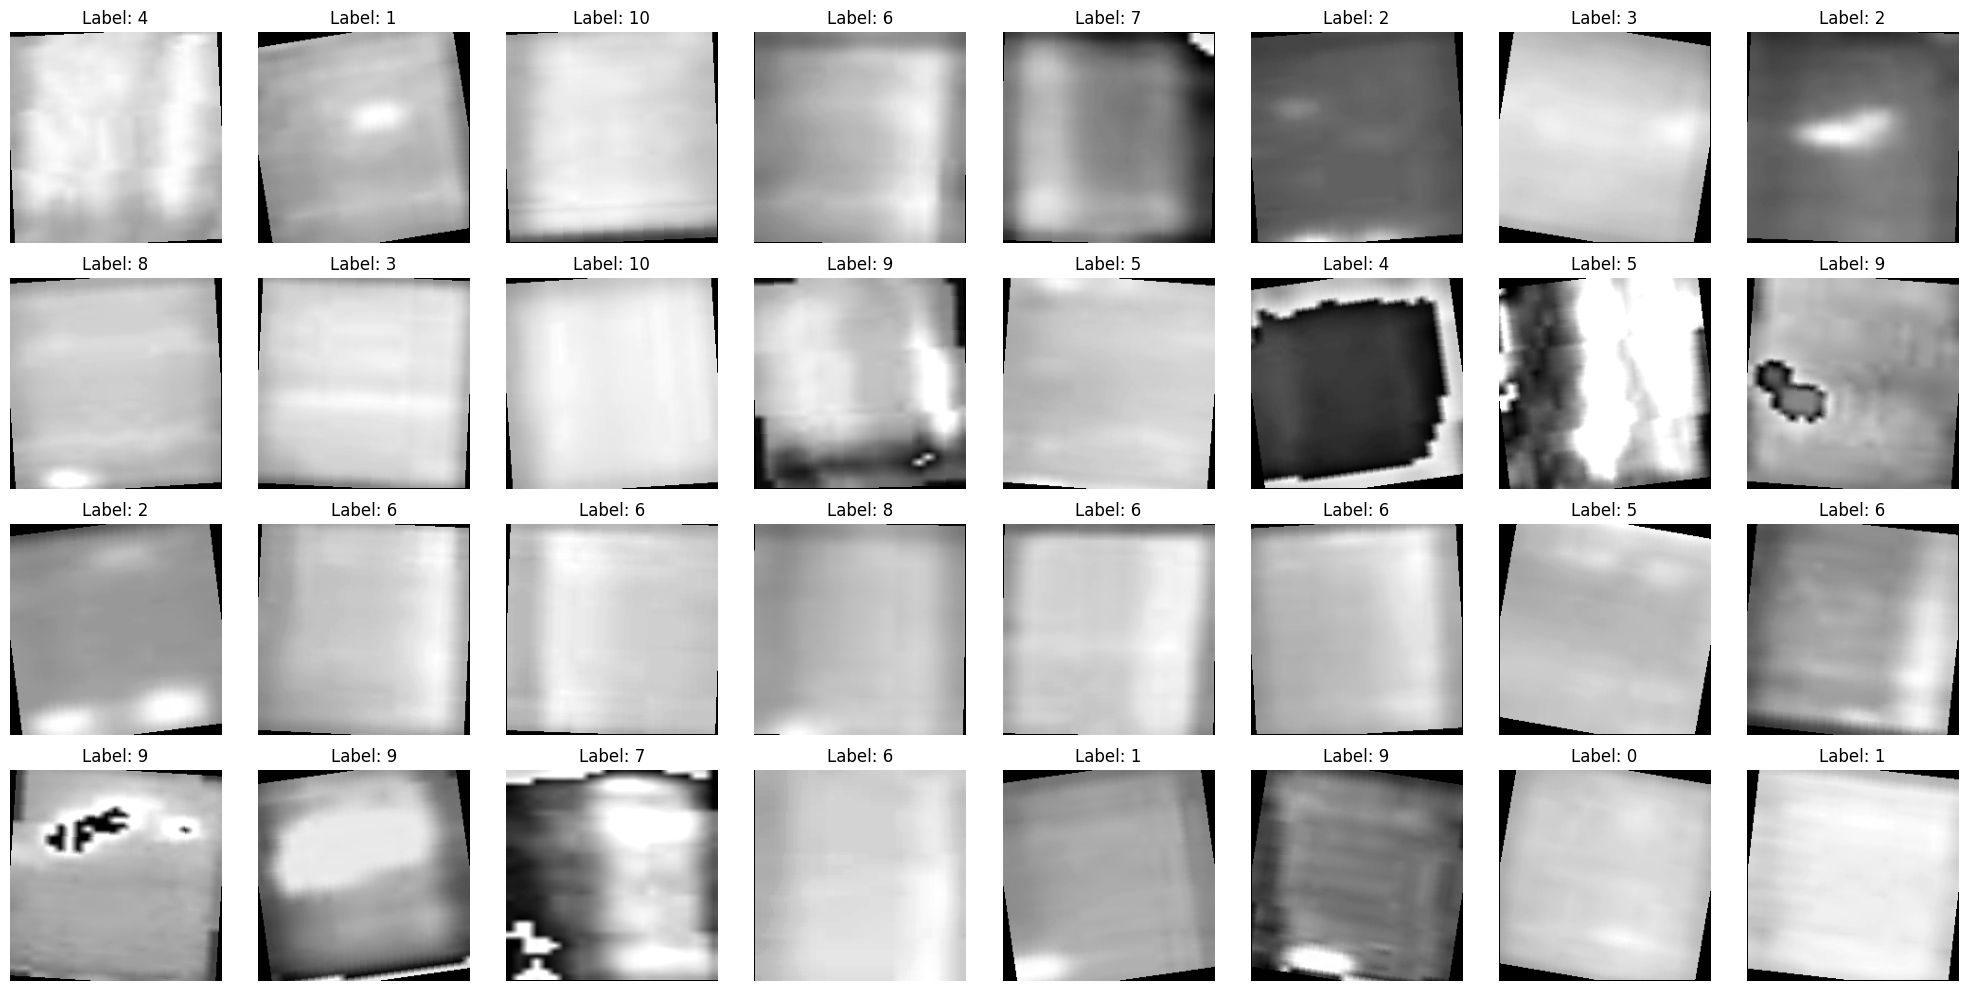

In [16]:
images_3b, labels_3b = next(iter(train_loader_3b))
print(labels_3b[0])

images_3b = images_3b * 0.5 + 0.5

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images_3b)):
    image = images_3b[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil, cmap='gray')
    axes[i].set_title(f"Label: {labels_3b[i].item()}")
    axes[i].axis('off')
print(images_3b[0].shape)
plt.tight_layout()
plt.show()

**EfficientNet Model**

In [17]:
model_3b = EfficientNet.from_pretrained('efficientnet-b0')

# EfficientNet expects 3 channels, so modify the first conv layer to accept 1 channel input
model_3b._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the final classification layer for 11 classes
model_3b._fc = nn.Linear(model_3b._fc.in_features, 11)

# Move model to device (GPU/CPU)
model_3b = model_3b.to(device)

# Compute class weights
class_labels = train_data_3b_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()  # Normalize class weights
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function and optimizer
loss_fn_3b = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer_3b = optim.Adam(model_3b.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_3b = ReduceLROnPlateau(optimizer_3b, mode='min', factor=0.1, patience=5)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 42.3MB/s]


Loaded pretrained weights for efficientnet-b0


**EfficientNet train function**

In [18]:
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, scheduler, num_epochs, device):
    best_model = None
    best_val_acc = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training
        model.train()
        train_loss, train_acc = 0.0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # CrossEntropyLoss expects integer class labels
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy for multi-class classification
            _, preds = torch.max(outputs, 1)  # Get predicted class indices
            train_acc += (preds == labels).sum().item() / len(labels)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)

                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                # Calculate accuracy for multi-class classification
                _, preds = torch.max(outputs, 1)  # Get predicted class indices
                val_acc += (preds == labels).sum().item() / len(labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        # Scheduler step
        scheduler.step(val_loss)

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {epoch_time:.2f}s")

    # Load the best model
    model.load_state_dict(best_model)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

**EfficientNet test function**

In [25]:
def test(model, dataloader, loss_fn, device):
    model.eval()
    model.to(device)

    test_loss, test_acc = 0, 0
    pred_labels = []
    true_labels = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            # Use the predicted class index
            _, preds = torch.max(outputs, 1)  # Get predicted class indices
            test_acc += (preds == labels).sum().item() / len(labels)

            pred_labels.extend(preds.cpu().tolist())  # Move to CPU and convert to list
            true_labels.extend(labels.cpu().tolist())  # Move to CPU and convert to list

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    print(f"Test Loss: {test_loss:.4f}, Test F1-Score: {f1:.4f}, Test Accuracy: {test_acc:.4f}")
    return test_loss, test_acc, true_labels, pred_labels


**EfficientNet training loop**

Epoch 1/20 - Train Loss: 1.7655, Train Acc: 0.3952, Val Loss: 1.5743, Val Acc: 0.4951, Time: 137.77s
Epoch 2/20 - Train Loss: 1.2067, Train Acc: 0.5821, Val Loss: 1.1268, Val Acc: 0.5986, Time: 140.54s
Epoch 3/20 - Train Loss: 1.0297, Train Acc: 0.6424, Val Loss: 0.9323, Val Acc: 0.6797, Time: 142.90s
Epoch 4/20 - Train Loss: 0.9065, Train Acc: 0.6844, Val Loss: 0.9230, Val Acc: 0.6826, Time: 136.87s
Epoch 5/20 - Train Loss: 0.8146, Train Acc: 0.7143, Val Loss: 0.8038, Val Acc: 0.7227, Time: 126.64s
Epoch 6/20 - Train Loss: 0.7453, Train Acc: 0.7303, Val Loss: 0.8368, Val Acc: 0.7148, Time: 127.62s
Epoch 7/20 - Train Loss: 0.6768, Train Acc: 0.7556, Val Loss: 0.8185, Val Acc: 0.7188, Time: 126.47s
Epoch 8/20 - Train Loss: 0.6133, Train Acc: 0.7772, Val Loss: 0.8141, Val Acc: 0.7246, Time: 127.37s
Epoch 9/20 - Train Loss: 0.5633, Train Acc: 0.7940, Val Loss: 0.8267, Val Acc: 0.7324, Time: 126.55s
Epoch 10/20 - Train Loss: 0.5203, Train Acc: 0.8115, Val Loss: 0.8311, Val Acc: 0.7275, Tim

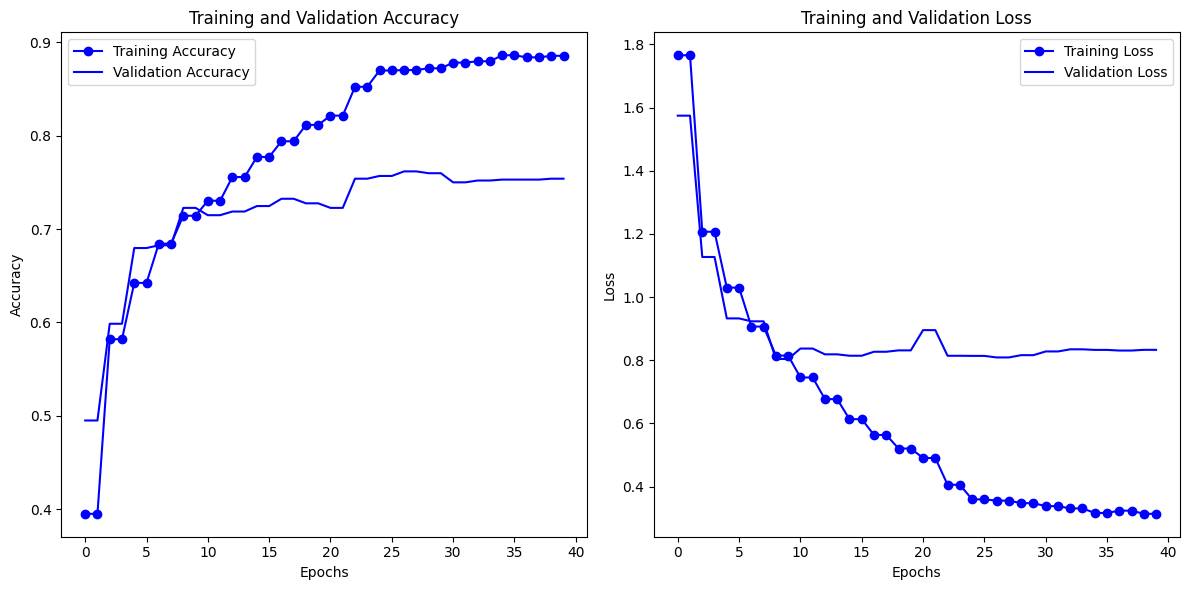

In [20]:
def saveModel(model: nn.Module, path):
    torch.save(model.state_dict(), path)

# Training process
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 20
best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model_3b, train_loader_3b, validation_loader_3b, loss_fn_3b, optimizer_3b, scheduler_3b, num_epochs, device)

# Save the model
save_path = "./myModel_best_3b.pth"
saveModel(best_model, save_path)

# Plot Training and Validation Curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(val_accuracies, 'b-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, 'bo-', label='Training Loss')
plt.plot(val_losses, 'b-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**EfficientNet test and confusion matrix**

<ipython-input-27-4be53437b5de>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_3b.load_state_dict(torch.load("myModel_best_3b.pth"))


Test Loss: 0.8221, Test F1-Score: 0.7490, Test Accuracy: 0.7471
EfficientNet Test Accuracy: 0.7470703125

Confusion Matrix for EfficientNet:


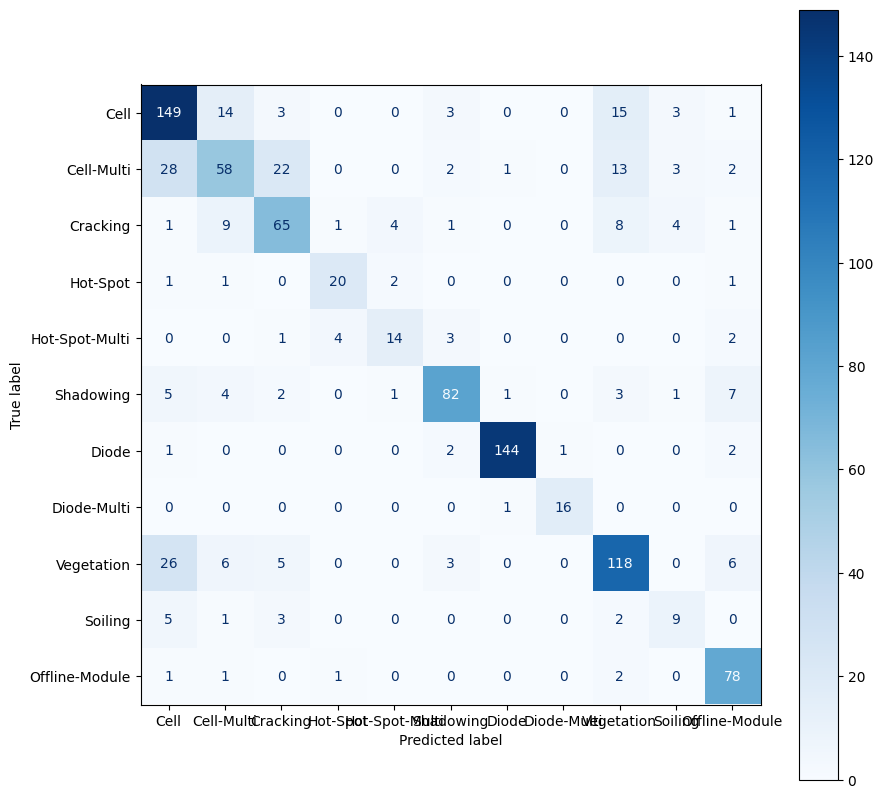

In [27]:
# Load the best model
model_3b.load_state_dict(torch.load("myModel_best_3b.pth"))

# Test the model
test_loss_efficientnet_3b, test_accuracy_efficientnet_3b, y_true_efficientnet_3b, y_pred_efficientnet_3b = test(
    model_3b, test_loader_3b, loss_fn_3b, device
)

print("EfficientNet Test Accuracy:", test_accuracy_efficientnet_3b)

# Function to plot confusion matrix
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

class_names_3b = ['Cell', 'Cell-Multi', 'Cracking', 'Hot-Spot', 'Hot-Spot-Multi', 'Shadowing', 'Diode', 'Diode-Multi', 'Vegetation', 'Soiling', 'Offline-Module']

# Plot confusion matrix for EfficientNet
print("\nConfusion Matrix for EfficientNet:")

plot_confusion_matrix(y_true_efficientnet_3b, y_pred_efficientnet_3b, class_names_3b)

## c)

**Label assigment and data split**

In [ ]:
# Binary Classification DataFrame
df_all_classes = df.copy()

# Substitution of string lables to numeric
df_all_classes['anomaly_class'] = df_all_classes['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11 if x == 'No-Anomaly'
              else 12
)

# Class distribution
df_all_classes_count = df_all_classes['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(df_all_classes_count)

#Train/Test ratio and split
train_ratio_3 = 0.9
train_data_3, test_data_3 = train_test_split(df_all_classes, test_size=(1 - train_ratio_3), train_size=train_ratio_3, random_state=2, stratify=df_all_classes['anomaly_class'])

train_data_3.reset_index(drop=True, inplace=True)
test_data_3.reset_index(drop=True, inplace=True)

Counts of each anomaly type:
anomaly_class
11    10000
0      1877
8      1639
6      1499
1      1288
5      1056
2       940
10      827
3       249
4       246
9       204
7       175
Name: count, dtype: int64


**Transformations**

In [ ]:
# Horizontal flip
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Vertical flip
transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

# Horzontal and Vertical flip
transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

# Train transform
train_transform = transforms.Compose([
    transforms.RandomRotation(10),                            # Random 10 degrees rotation
    #transforms.RandomCrop((40, 24), padding=1),              # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),     # Color jitter
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                    # Conversion to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])               # Normalization
])

# Test Transfomr
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                                    # Conversion to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])               # Normalization
])

**Data Augmentation**

In [ ]:
train_data_3_counts = train_data_3['anomaly_class'].value_counts()
print("Counts of each anomaly type(Initial):")
print(train_data_3_counts)
print("\nInitial Size:", len(train_data_3), "\n")

# Datasets
train_data_3_balanced = train_data_3.copy()

largest_class_count = train_data_3_counts.max()                     #
ratios = largest_class_count / train_data_3_counts                  #
max_ratio = 4                                                       #
ratios = np.minimum(ratios, max_ratio)                              #
ratios_sorted = ratios.sort_index()                                 # Ratios Calculations
ratios_matrix=[]                                                    #
for label, ratio in ratios_sorted.items():                          #
    ratios_matrix.append([label, ratio])                            #
print(ratios_matrix)                                                #



directory = "/content/images_3"                                     #
if os.path.exists(directory):                                       #
    for filename in os.listdir(directory):                          #
        file_path = os.path.join(directory, filename)               #
        try:                                                        #
            if os.path.isdir(file_path):                            #
                shutil.rmtree(file_path)                            # Folder creation for new images
            else:                                                   #
                os.remove(file_path)                                #
        except Exception as e:                                      #
            print(f"Error deleting file {file_path}: {e}")          #
else:                                                               #
    os.makedirs(directory, exist_ok=True)                           #


# Augmentation
for i in range(len(train_data_3)):
    row = train_data_3.iloc[i]
    image_path = row["image_filepath"]
    label = row["anomaly_class"]

    image_pil = Image.open(image_path).convert("L")

    ratio = ratios_matrix[int(label)][1]

    int_part = int(ratio)
    frac_part = ratio - int_part
    num1,num2 = random.sample(range(1, 3), 2)

    for n in range(int_part-1):
        if(n==0):
            transform_augmentation = transform_augmentation_1
        elif(n==1):
            transform_augmentation = transform_augmentation_2
        elif(n==2):
            transform_augmentation = transform_augmentation_3

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_3_balanced = pd.concat([train_data_3_balanced, pd.DataFrame([new_row])], ignore_index=True)

train_data_3_balanced_counts = train_data_3_balanced['anomaly_class'].value_counts()
print("\n\nCounts of each anomaly type(Augmented):")
print(train_data_3_balanced_counts)
print("\nAugmented Size:", len(train_data_3_balanced))

Counts of each anomaly type(Initial):
anomaly_class
11    9000
0     1689
8     1475
6     1349
1     1159
5      950
2      846
10     744
3      224
4      222
9      184
7      158
Name: count, dtype: int64

Initial Size: 18000 

[[0, 4.0], [1, 4.0], [2, 4.0], [3, 4.0], [4, 4.0], [5, 4.0], [6, 4.0], [7, 4.0], [8, 4.0], [9, 4.0], [10, 4.0], [11, 1.0]]


Counts of each anomaly type(Augmented):
anomaly_class
11    9000
0     6756
8     5900
6     5396
1     4636
5     3800
2     3384
10    2976
3      896
4      888
9      736
7      632
Name: count, dtype: int64

Augmented Size: 45000


**Dataset class**

In [ ]:
class MyImageDataset_c(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

**Train and test data loaders**

In [ ]:
# DataLoaders
train_dataset_3_balanced = MyImageDataset_c(metadata=train_data_3_balanced, transform=train_transform)
test_dataset_3 = MyImageDataset_c(metadata=test_data_3, transform=test_transform)

batch_size = 32
train_loader_3 = data.DataLoader(dataset=train_dataset_3_balanced, batch_size=batch_size, shuffle=True)
test_loader_3 = data.DataLoader(dataset=test_dataset_3, batch_size=batch_size, shuffle=False)

Image size torch.Size([1, 224, 224])


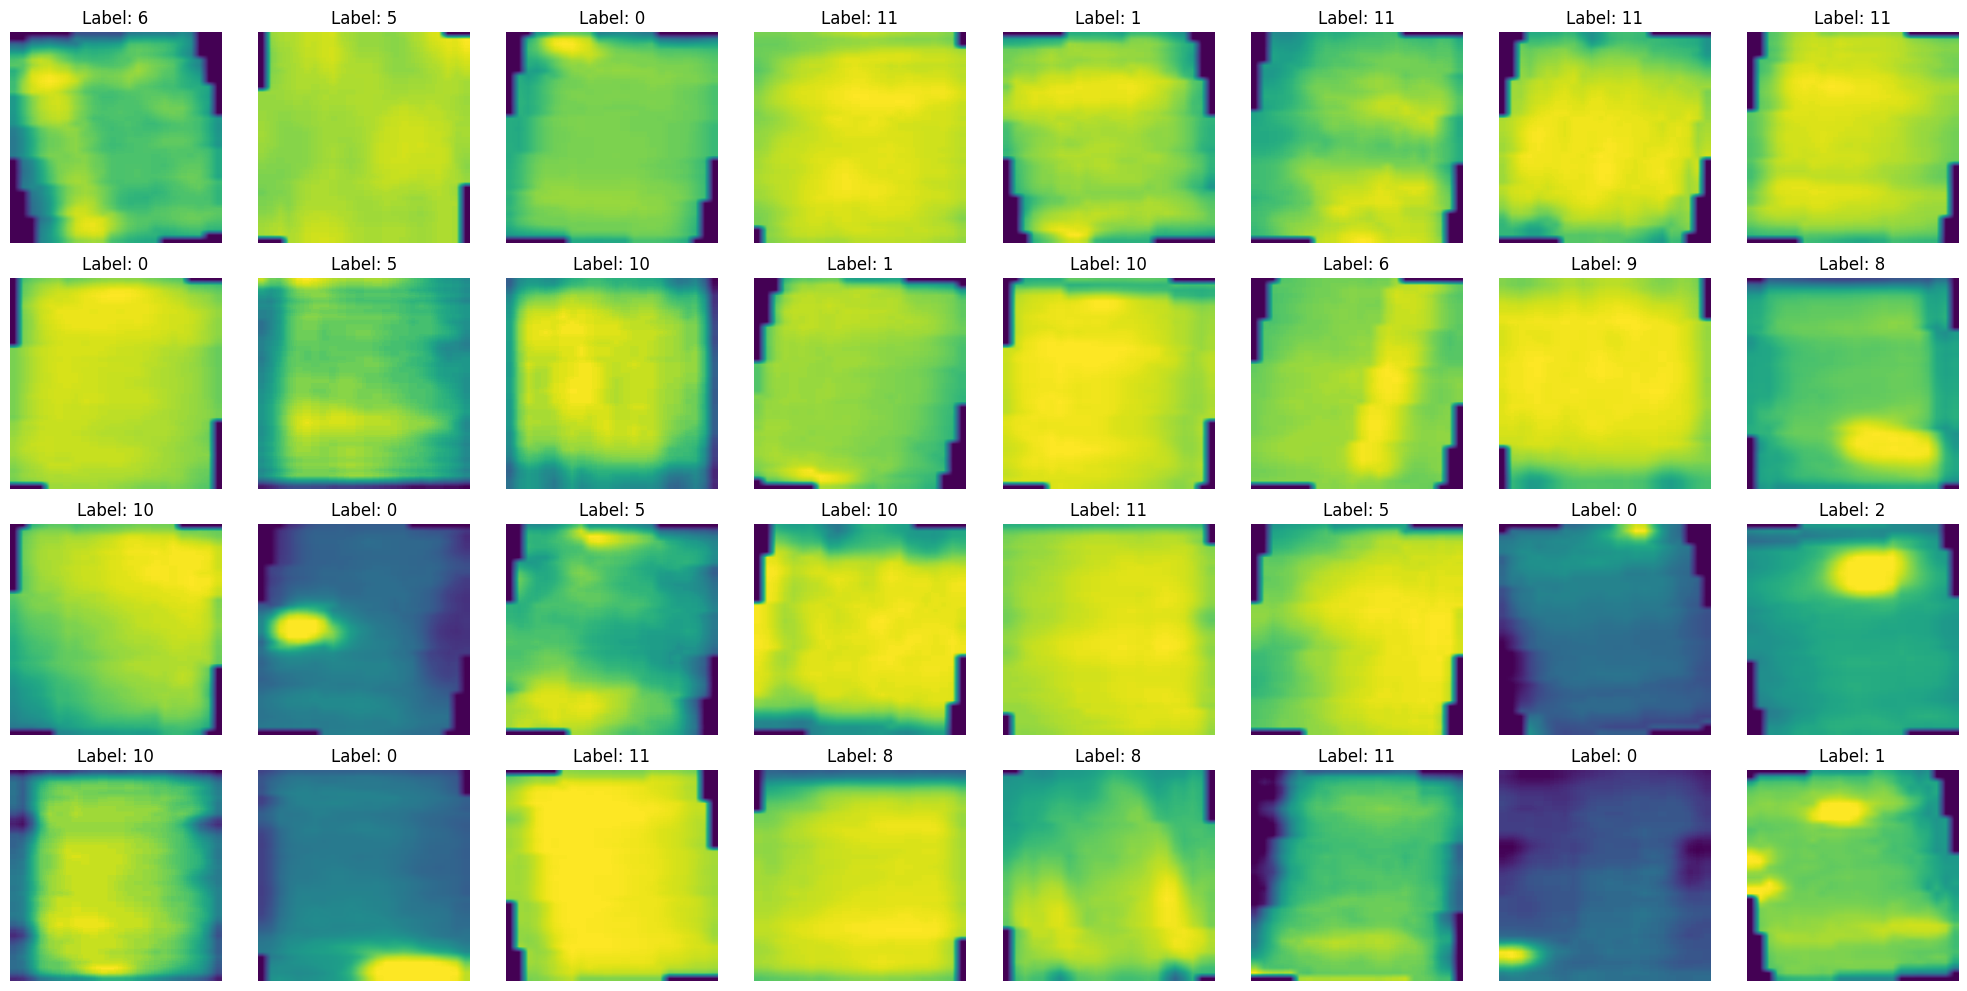

In [ ]:
# Show of a batch
images_3, labels_3 = next(iter(train_loader_3))
images_3 = images_3 * 0.5 + 0.5

fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
for i in range(len(images_3)):
    image = images_3[i]
    image_pil = transforms.ToPILImage()(image)
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels_3[i].item()}")
    axes[i].axis('off')

print("Image size", images_3[0].shape)
plt.tight_layout()
plt.show()

**EfficientNet Model**

In [ ]:
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0')

# Modify the first convolutional layer to accept grayscale images (1 channel)
# EfficientNet expects 3 channels, so we modify the first conv layer to accept 1 channel input
efficientnet_model._conv_stem = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the final classification layer for 12 classes
efficientnet_model._fc = nn.Linear(efficientnet_model._fc.in_features, 12)

# Send the model to the device (GPU or CPU)
efficientnet_model = efficientnet_model.to(device)

# Compute class weights based on class distribution
class_labels = train_data_3_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss function and optimizer
loss_fn_efficientnet = nn.CrossEntropyLoss(weight=class_weights).to(device)
optimizer_efficientnet = optim.Adam(efficientnet_model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_efficientnet = ReduceLROnPlateau(optimizer_efficientnet, mode='min', factor=0.1, patience=5)


Loaded pretrained weights for efficientnet-b0


**EfficientNet train function**

In [ ]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    avg_loss = train_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy

**EfficientNet test function**

In [ ]:
def test(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_loss = test_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy, y_true, y_pred

**EfficientNet training loop**

In [ ]:
# Training loop
import time

num_epochs = 20
best_accuracy = 0.0

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_accuracy = train(efficientnet_model, train_loader_3, loss_fn_efficientnet, optimizer_efficientnet, device)
    test_loss, test_accuracy, _, _ = test(efficientnet_model, test_loader_3, loss_fn_efficientnet, device)

    # Step scheduler
    scheduler_efficientnet.step(test_loss)

    # Save the best model
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(efficientnet_model.state_dict(), "efficientnet_best_model_gray.pth")

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch time: {epoch_time:.2f} seconds\n")

Epoch 1/20
Train Loss: 1.5000, Train Accuracy: 0.4738
Test Loss: 1.0484, Test Accuracy: 0.6945
Epoch time: 355.06 seconds

Epoch 2/20
Train Loss: 1.0135, Train Accuracy: 0.6347
Test Loss: 0.8616, Test Accuracy: 0.7310
Epoch time: 352.75 seconds

Epoch 3/20
Train Loss: 0.8543, Train Accuracy: 0.6877
Test Loss: 0.7911, Test Accuracy: 0.7495
Epoch time: 352.99 seconds

Epoch 4/20
Train Loss: 0.7428, Train Accuracy: 0.7223
Test Loss: 0.7674, Test Accuracy: 0.7800
Epoch time: 353.06 seconds

Epoch 5/20
Train Loss: 0.6656, Train Accuracy: 0.7439
Test Loss: 0.7100, Test Accuracy: 0.7970
Epoch time: 352.84 seconds

Epoch 6/20
Train Loss: 0.5979, Train Accuracy: 0.7645
Test Loss: 0.6894, Test Accuracy: 0.8140
Epoch time: 352.93 seconds

Epoch 7/20
Train Loss: 0.5444, Train Accuracy: 0.7821
Test Loss: 0.7510, Test Accuracy: 0.8050
Epoch time: 352.66 seconds

Epoch 8/20
Train Loss: 0.4896, Train Accuracy: 0.7995
Test Loss: 0.7695, Test Accuracy: 0.8070
Epoch time: 352.11 seconds

Epoch 9/20
Train

**EfficientNet test and confusion matrix**

In [ ]:
# Load the best model
efficientnet_model.load_state_dict(torch.load("efficientnet_best_model_gray.pth"))

# Test the model
test_loss_efficientnet, test_accuracy_efficientnet, y_true_efficientnet, y_pred_efficientnet = test(
    efficientnet_model, test_loader_3, loss_fn_efficientnet, device
)

print("EfficientNet Test Accuracy:", test_accuracy_efficientnet)

<ipython-input-26-82fdbb6f0333>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  efficientnet_model.load_state_dict(torch.load("efficientnet_best_model_gray.pth"))


EfficientNet Test Accuracy: 0.8415



Confusion Matrix for EfficientNet:


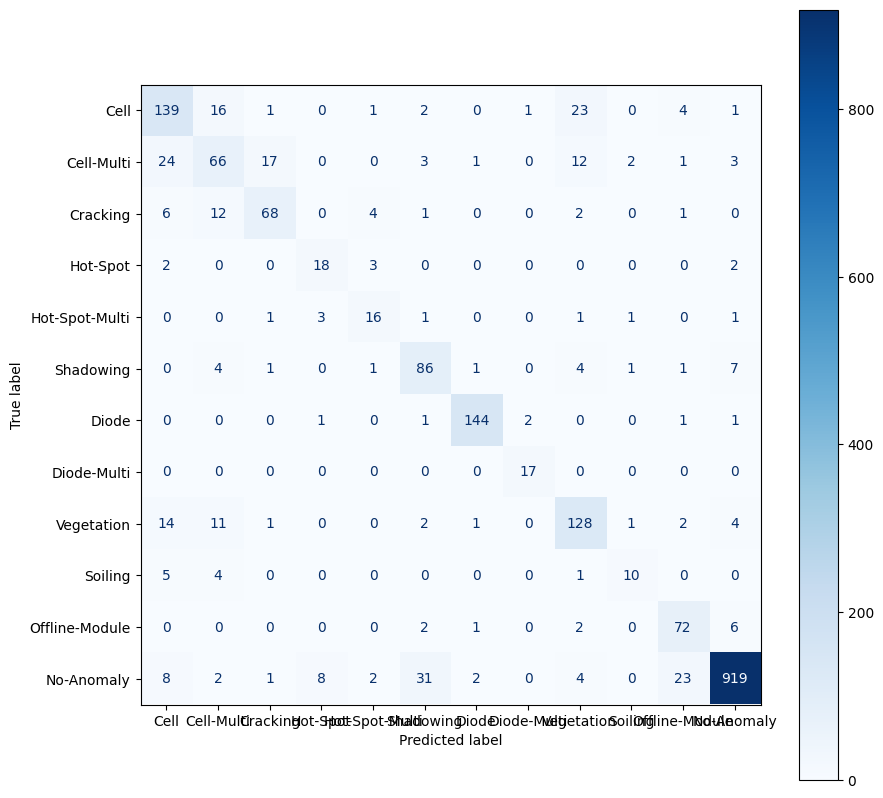

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(labels, pred_labels, class_names):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d', cmap='Blues', ax=ax)
    plt.show()

class_names_c = ['Cell', 'Cell-Multi', 'Cracking', 'Hot-Spot', 'Hot-Spot-Multi', 'Shadowing', 'Diode', 'Diode-Multi', 'Vegetation', 'Soiling', 'Offline-Module', 'No-Anomaly']

# Plot confusion matrix for EfficientNet
print("\nConfusion Matrix for EfficientNet:")
plot_confusion_matrix(y_true_efficientnet, y_pred_efficientnet, class_names_c)

# 4

When comparing the results of the model described in the article with those of the one we developed, we can conclude that the article's model achieved significantly higher results than ours. This difference is justified by the methodology adopted in that model. Both models use preprocessing and data augmentation methods, which process the images before they are used and increase the amount of data available, among other processes. Since both models employ these methods, this cannot be the source of the discrepancy, leading us to conclude that the difference arises from a process applied in the article's model called ViT. This model divides each image into smaller blocks called patches, unlike CNNs, which analyze images as a whole. Each patch is analyzed individually but is related to other patches in the same image to identify global dependencies. This methodology proves to be highly efficient, as evidenced by the difference in results, especially in models with large amounts of data.

